# 分析川普相關文章之詞彙關係及主題分析(第八組)

# 1. 文辭和文件分析

### 1.1 套件說明
- pandas：一個資料分析的函式庫，提供了 DataFrame 等資料格式，與資料處理的函數。
- numpy：為科學運算所提供的套件。提供許多數學公式的實作以及高效率的陣列、矩陣運算。
- NLTK：全名為 Natural Language Tool Kit，自然語言處理工具。
- jieba：中文斷詞套件。
- re：正規表達式套件。
- math：數學運算工具。
- collections：提供額外的數據類型。
- matplotlib：繪圖工具。
- networkx：網絡圖建構、繪製工具。
- CountVectorizer, TfidfTransformer：sklearn 中計算詞頻與 tf-idf 的套件。
- numpy.linalg：矩陣與向量運算套件。

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import re
import jieba
import jieba.analyse
import math
from nltk import ngrams, FreqDist
from collections import Counter, namedtuple

import networkx as nx
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
# 使圖中中文能正常顯示
# plt.rcParams['font.sans-serif'] = ['Arial Unicode Ms'] # MacOS
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']

# 使負號能夠顯示 
plt.rcParams['axes.unicode_minus'] = False

### 1.2 資料前處理
#### 1.2.1 資料來源
+ TarFlow 蒐集 PTT 股票版（Stock）文章  
+ 關鍵字：「川普」、「美國總統」  
+ 時間：2025-01-21 ~ 2025-04-16  
+ 資料筆數：共 3467 篇文章

In [3]:
# 匯入資料
df = pd.read_csv('./raw_data/ptt_stock_Trump.csv', encoding = 'UTF-8')
df.head()

,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource
0,1,https://www.ptt.cc/bbs/Stock/M.1737417946.A.13...,[新聞]TV面板價揚超大尺寸需求最旺雙虎吞補丸,2025-01-21 08:05:43,MacBookAir12,Stock,原文標題：\nTV 面板價揚 超大尺寸需求最旺 雙虎吞補丸\n\n原文連結：\nhttps:...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""cysfmc"", ""cm...",175.181.186.182,2025-02-21 19:14:13,ptt
1,2,https://www.ptt.cc/bbs/Stock/M.1737419603.A.CC...,[新聞]川普就職演說十重點一次掌握,2025-01-21 08:33:20,xephon,Stock,原文標題：\n原文連結：\nhttps://udn.com/news/amp/story/1...,"[{""cmtStatus"": ""→"", ""cmtPoster"": ""adngg579"", ""...",49.216.47.118,2025-02-21 19:14:42,ptt
2,3,https://www.ptt.cc/bbs/Stock/M.1737424473.A.6C...,[新聞]快訊／川普簽行政命令 宣布美國退出世,2025-01-21 09:54:30,a5687920,Stock,原文標題：\n\n快訊／川普簽行政命令 宣布美國退出世界衛生組織\n原文連結：\nhttps...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""fujioqq"", ""c...",1.200.145.107,2025-02-21 19:14:42,ptt
3,4,https://www.ptt.cc/bbs/Stock/M.1737424798.A.8A...,[新聞]川普擬對加拿大、墨西哥「課徵25%關稅」,2025-01-21 09:59:56,leptoneta,Stock,川普擬對加拿大、墨西哥「課徵25%關稅」 2月1日生效\nhttps://www.ettod...,"[{""cmtStatus"": ""→"", ""cmtPoster"": ""house911"", ""...",220.128.223.151,2025-02-21 19:14:42,ptt
4,5,https://www.ptt.cc/bbs/Stock/M.1737426377.A.E7...,[新聞]川普就職宣布撤銷電動車補助大規模開採,2025-01-21 10:26:14,leptoneta,Stock,川普就職宣布撤銷電動車補助 大規模開採石油\nhttps://netzero.cna.com...,"[{""cmtStatus"": ""→"", ""cmtPoster"": ""calmerrorans...",220.128.223.151,2025-02-21 19:14:42,ptt


#### 1.2.2 資料清理
- 去除特殊字元與標點符號，只留下中文字
- \u4e00-\u9fff 為 Unicode 中文漢字字符的範圍

In [4]:
MetaData = df.copy()

# 去除一些不需要的欄位
MetaData = MetaData.drop(['artPoster', 'artCatagory', 'artComment', 'e_ip', 'insertedDate', 'dataSource'], axis=1)
# 過濾掉缺失值 NaN 後，只留下中文字
MetaData['sentence'] = MetaData['artContent'].apply(lambda x: re.sub('[^\u4e00-\u9fff]+', '', x) if isinstance(x, str) else '')

MetaData.head()

,system_id,artUrl,artTitle,artDate,artContent,sentence
0,1,https://www.ptt.cc/bbs/Stock/M.1737417946.A.13...,[新聞]TV面板價揚超大尺寸需求最旺雙虎吞補丸,2025-01-21 08:05:43,原文標題：\nTV 面板價揚 超大尺寸需求最旺 雙虎吞補丸\n\n原文連結：\nhttps:...,原文標題面板價揚超大尺寸需求最旺雙虎吞補丸原文連結發布時間記者署名經濟日報記者李珣瑛新竹報導...
1,2,https://www.ptt.cc/bbs/Stock/M.1737419603.A.CC...,[新聞]川普就職演說十重點一次掌握,2025-01-21 08:33:20,原文標題：\n原文連結：\nhttps://udn.com/news/amp/story/1...,原文標題原文連結發布時間記者署名編譯任中原綜合外電原文內容川普周一美國總統就職演說摘錄如下川...
2,3,https://www.ptt.cc/bbs/Stock/M.1737424473.A.6C...,[新聞]快訊／川普簽行政命令 宣布美國退出世,2025-01-21 09:54:30,原文標題：\n\n快訊／川普簽行政命令 宣布美國退出世界衛生組織\n原文連結：\nhttps...,原文標題快訊川普簽行政命令宣布美國退出世界衛生組織原文連結發布時間記者署名丘力龍原文內容美國...
3,4,https://www.ptt.cc/bbs/Stock/M.1737424798.A.8A...,[新聞]川普擬對加拿大、墨西哥「課徵25%關稅」,2025-01-21 09:59:56,川普擬對加拿大、墨西哥「課徵25%關稅」 2月1日生效\nhttps://www.ettod...,川普擬對加拿大墨西哥課徵關稅月日生效新聞雲記者吳美依美國總統川普日中午宣誓就職再度入主白宮成...
4,5,https://www.ptt.cc/bbs/Stock/M.1737426377.A.E7...,[新聞]川普就職宣布撤銷電動車補助大規模開採,2025-01-21 10:26:14,川普就職宣布撤銷電動車補助 大規模開採石油\nhttps://netzero.cna.com...,川普就職宣布撤銷電動車補助大規模開採石油中央社記者林宏翰美國第位總統川普今天宣誓就職他在就職...


#### 1.2.3 文章斷詞與整理
根據資料集特色，加入自定義的斷詞及停用字

In [5]:
# 設定繁體中文詞庫
jieba.set_dictionary('./dict/dict.txt.big')

# 加入自定義詞彙
jieba.add_word("川普")
jieba.add_word("台積電")
jieba.add_word("盧特尼克")  # 美國商務部長
jieba.add_word("那斯達克")  # 股票市場指數
jieba.add_word("道瓊工業")  # 股票市場指數
jieba.add_word("國安基金")
jieba.add_word("先進製程")
jieba.add_word("澤倫斯基")  # 烏克蘭總統

# 新增 stopwords
with open('./dict/stopwords.txt',encoding="utf-8") as f:
    stopWords = [line.strip() for line in f.readlines()]

# 新增自定義停用字
other_stopwords = ['原文', '標題', '連結', '記者', '署名', '內容', '心得', '評論', '發布', '時間']
stopWords += other_stopwords

Building prefix dict from d:\113-2 SMA\讀書會\report2\dict\dict.txt.big ...
Loading model from cache C:\Users\HM-B01\AppData\Local\Temp\jieba.uc38b0eb146461e7dac235730a431b7c0.cache
Loading model cost 1.433 seconds.
Prefix dict has been built successfully.


In [6]:
# 設定斷詞 function
def getToken(row):
    # 進行斷詞
    seg_list = jieba.lcut(row)
    # 篩選掉停用字與字元數小於 1 的詞彙
    seg_list = [w for w in seg_list if w not in stopWords and len(w)>1]

    return seg_list

In [7]:
data = MetaData.copy()

# 斷詞、去除停用字
data['word'] = data.sentence.apply(getToken)
# 將 word 欄位展開
data = data.explode('word').reset_index(drop=True)

data.head()

,system_id,artUrl,artTitle,artDate,artContent,sentence,word
0,1,https://www.ptt.cc/bbs/Stock/M.1737417946.A.13...,[新聞]TV面板價揚超大尺寸需求最旺雙虎吞補丸,2025-01-21 08:05:43,原文標題：\nTV 面板價揚 超大尺寸需求最旺 雙虎吞補丸\n\n原文連結：\nhttps:...,原文標題面板價揚超大尺寸需求最旺雙虎吞補丸原文連結發布時間記者署名經濟日報記者李珣瑛新竹報導...,面板
1,1,https://www.ptt.cc/bbs/Stock/M.1737417946.A.13...,[新聞]TV面板價揚超大尺寸需求最旺雙虎吞補丸,2025-01-21 08:05:43,原文標題：\nTV 面板價揚 超大尺寸需求最旺 雙虎吞補丸\n\n原文連結：\nhttps:...,原文標題面板價揚超大尺寸需求最旺雙虎吞補丸原文連結發布時間記者署名經濟日報記者李珣瑛新竹報導...,價揚
2,1,https://www.ptt.cc/bbs/Stock/M.1737417946.A.13...,[新聞]TV面板價揚超大尺寸需求最旺雙虎吞補丸,2025-01-21 08:05:43,原文標題：\nTV 面板價揚 超大尺寸需求最旺 雙虎吞補丸\n\n原文連結：\nhttps:...,原文標題面板價揚超大尺寸需求最旺雙虎吞補丸原文連結發布時間記者署名經濟日報記者李珣瑛新竹報導...,超大
3,1,https://www.ptt.cc/bbs/Stock/M.1737417946.A.13...,[新聞]TV面板價揚超大尺寸需求最旺雙虎吞補丸,2025-01-21 08:05:43,原文標題：\nTV 面板價揚 超大尺寸需求最旺 雙虎吞補丸\n\n原文連結：\nhttps:...,原文標題面板價揚超大尺寸需求最旺雙虎吞補丸原文連結發布時間記者署名經濟日報記者李珣瑛新竹報導...,尺寸
4,1,https://www.ptt.cc/bbs/Stock/M.1737417946.A.13...,[新聞]TV面板價揚超大尺寸需求最旺雙虎吞補丸,2025-01-21 08:05:43,原文標題：\nTV 面板價揚 超大尺寸需求最旺 雙虎吞補丸\n\n原文連結：\nhttps:...,原文標題面板價揚超大尺寸需求最旺雙虎吞補丸原文連結發布時間記者署名經濟日報記者李珣瑛新竹報導...,需求


使用文字雲，視覺化斷詞後的結果

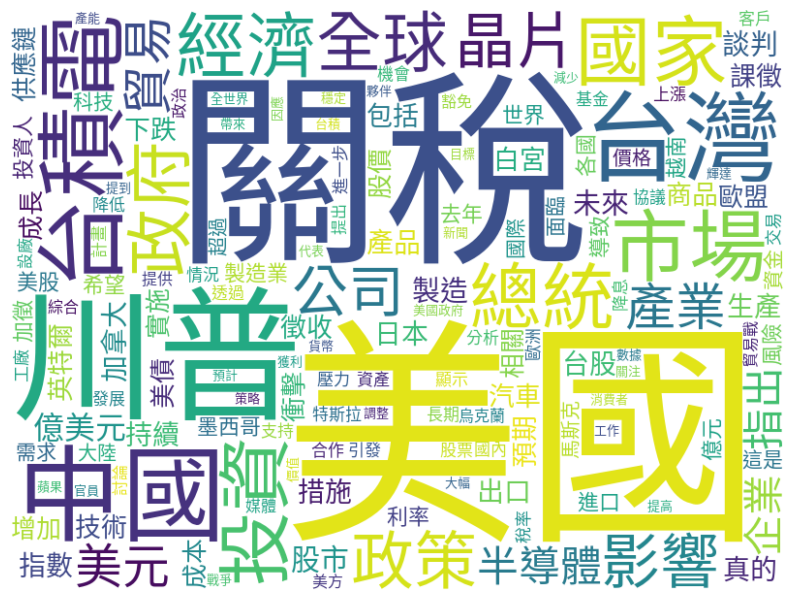

In [8]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# 統計每個詞出現的次數
word_freq = data['word'].value_counts().to_dict()

# 產生文字雲
wc = WordCloud(font_path='./dict/SourceHanSansTW-Regular.otf',  # 指定中文字型路徑
               width=800, height=600, 
               background_color='white',
               max_words=150)

wc.generate_from_frequencies(word_freq)

# 顯示文字雲
plt.figure(figsize=(10, 8))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

### 1.3 找出重要詞彙（以 TF-IDF 為例）

#### 1.3.1 使用公式

In [9]:
# 計算個文章的總詞彙數
total_words = data.groupby(['system_id'], as_index=False).size().rename(columns={'size': 'total'})
total_words.head()

,system_id,total
0,1,294
1,2,132
2,3,42
3,4,113
4,5,151


In [10]:
# 計算各文章的各個詞彙數
word_count = data.groupby(['system_id', 'word'], as_index = False).size()

word_count.rename(columns={'size': 'count'}, inplace=True)
word_count.sort_values('count', ascending=False).head()

,system_id,word,count
181784,1746,億美元,104
265771,2681,美國,92
37556,401,中國,72
192144,1848,美國,68
328745,3369,中國,58


In [11]:
# 合併「每個詞彙在每篇文章中出現的次數」與「每篇文章的詞數」
data_merged = word_count.merge(total_words, on = 'system_id', how = 'left')
data_merged.head()

,system_id,word,count,total
0,1,上季,1,294
1,1,上將,1,294
2,1,上漲,1,294
3,1,下旬,1,294
4,1,不明朗,1,294


In [12]:
# 計算 tf = 詞彙在該文件中出現次數 / 該文件中詞彙總數 
data_tf = data_merged.assign(tf = data_merged["count"] / data_merged["total"])
data_tf.head()

,system_id,word,count,total,tf
0,1,上季,1,294,0.003401
1,1,上將,1,294,0.003401
2,1,上漲,1,294,0.003401
3,1,下旬,1,294,0.003401
4,1,不明朗,1,294,0.003401


In [13]:
# 計算每個詞彙出現在幾篇文章中
idf_df = data_merged.groupby(['word'], as_index = False).size()

# 合併到之前的 df 中
data_idf = data_tf.merge(idf_df, on = 'word', how = 'left')

data_idf.head()

,system_id,word,count,total,tf,size
0,1,上季,1,294,0.003401,7
1,1,上將,1,294,0.003401,11
2,1,上漲,1,294,0.003401,252
3,1,下旬,1,294,0.003401,6
4,1,不明朗,1,294,0.003401,22


In [14]:
# 計算 idf = log ( 總文件數量 / 包含該詞彙的文件數量 ) 
data_tf_idf = data_idf.assign(idf = data_idf["size"].apply(lambda size: math.log( len(total_words) / size, 10 ))).drop(["size"], axis=1)

data_tf_idf.head()

,system_id,word,count,total,tf,idf
0,1,上季,1,294,0.003401,2.694856
1,1,上將,1,294,0.003401,2.498561
2,1,上漲,1,294,0.003401,1.138553
3,1,下旬,1,294,0.003401,2.761803
4,1,不明朗,1,294,0.003401,2.197531


In [15]:
# 計算 tf * idf
data_tf_idf = data_tf_idf.assign(tf_idf = data_tf_idf["tf"] * data_tf_idf["idf"])

data_tf_idf.sort_values('tf_idf', ascending = False).head(10)

,system_id,word,count,total,tf,idf,tf_idf
124375,1213,烏已,1,3,0.333333,3.539954,1.179985
124371,1212,剛剛,1,2,0.500000,1.733774,0.866887
99706,989,啪啪,2,8,0.250000,3.238924,0.809731
251727,2528,現大,1,4,0.250000,3.238924,0.809731
251726,2528,上隊,1,4,0.250000,3.238924,0.809731
251728,2528,設者,1,4,0.250000,3.238924,0.809731
251729,2528,適公是,1,4,0.250000,3.238924,0.809731
315440,3246,電梯,1,4,0.250000,2.937894,0.734473
330278,3379,短債,2,7,0.285714,2.426010,0.693146
289414,2987,戰果,4,19,0.210526,3.238924,0.681879


In [16]:
# 選出每個文件，tf-idf 值最大的前三個詞
group = data_tf_idf.groupby("system_id").apply(lambda x : x.nlargest(3, "tf_idf"))
group.head(15)

C:\Users\HM-B01\AppData\Local\Temp\ipykernel_12456\48416988.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  group = data_tf_idf.groupby("system_id").apply(lambda x : x.nlargest(3, "tf_idf"))


system_id    word  count  total        tf       idf    tf_idf
system_id                                                                   
1         159          1      面板     22    294  0.074830  2.217735  0.165953
          156          1      電視      9    294  0.030612  1.916705  0.058675
          50           1      尺寸      5    294  0.017007  2.840984  0.048316
2         179          2      再度      5    132  0.037879  1.429364  0.054143
          171          2      他將      3    132  0.022727  1.799591  0.040900
          191          2      團結      2    132  0.015152  2.261200  0.034261
3         268          3  世界衛生組織      2     42  0.047619  3.238924  0.154234
          291          3      退出      3     42  0.071429  1.916705  0.136907
          281          3      百條      1     42  0.023810  3.539954  0.084285
4         365          4      課徵      6    113  0.053097  0.952243  0.050562
          375          4      鄰國      2    113  0.017699  2.284681  0.040437
          354          4     第一天      2    113  0.017699  2.238924  0.039627
5         446          5      石油      6    151  0.039735  1.514648  0.060185
          469          5      開採      3    151  0.019868  2.238924  0.044482
          473          5     電動車      4    151  0.026490  1.600435  0.042396

#### 1.3.2 使用套件

In [17]:
stock_df = MetaData.copy()
stock_df.head()

,system_id,artUrl,artTitle,artDate,artContent,sentence
0,1,https://www.ptt.cc/bbs/Stock/M.1737417946.A.13...,[新聞]TV面板價揚超大尺寸需求最旺雙虎吞補丸,2025-01-21 08:05:43,原文標題：\nTV 面板價揚 超大尺寸需求最旺 雙虎吞補丸\n\n原文連結：\nhttps:...,原文標題面板價揚超大尺寸需求最旺雙虎吞補丸原文連結發布時間記者署名經濟日報記者李珣瑛新竹報導...
1,2,https://www.ptt.cc/bbs/Stock/M.1737419603.A.CC...,[新聞]川普就職演說十重點一次掌握,2025-01-21 08:33:20,原文標題：\n原文連結：\nhttps://udn.com/news/amp/story/1...,原文標題原文連結發布時間記者署名編譯任中原綜合外電原文內容川普周一美國總統就職演說摘錄如下川...
2,3,https://www.ptt.cc/bbs/Stock/M.1737424473.A.6C...,[新聞]快訊／川普簽行政命令 宣布美國退出世,2025-01-21 09:54:30,原文標題：\n\n快訊／川普簽行政命令 宣布美國退出世界衛生組織\n原文連結：\nhttps...,原文標題快訊川普簽行政命令宣布美國退出世界衛生組織原文連結發布時間記者署名丘力龍原文內容美國...
3,4,https://www.ptt.cc/bbs/Stock/M.1737424798.A.8A...,[新聞]川普擬對加拿大、墨西哥「課徵25%關稅」,2025-01-21 09:59:56,川普擬對加拿大、墨西哥「課徵25%關稅」 2月1日生效\nhttps://www.ettod...,川普擬對加拿大墨西哥課徵關稅月日生效新聞雲記者吳美依美國總統川普日中午宣誓就職再度入主白宮成...
4,5,https://www.ptt.cc/bbs/Stock/M.1737426377.A.E7...,[新聞]川普就職宣布撤銷電動車補助大規模開採,2025-01-21 10:26:14,川普就職宣布撤銷電動車補助 大規模開採石油\nhttps://netzero.cna.com...,川普就職宣布撤銷電動車補助大規模開採石油中央社記者林宏翰美國第位總統川普今天宣誓就職他在就職...


In [18]:
# 保留需要的欄位
stock_df = stock_df.loc[:,["system_id", "sentence"]]

# 斷詞、去除停用字
stock_df['word'] = stock_df.sentence.apply(getToken).map(' '.join)

stock_df.head()

,system_id,sentence,word
0,1,原文標題面板價揚超大尺寸需求最旺雙虎吞補丸原文連結發布時間記者署名經濟日報記者李珣瑛新竹報導...,面板 價揚 超大 尺寸 需求 最旺 雙虎 吞補丸 經濟日報 李珣瑛 新竹 集邦 科技 昨日 ...
1,2,原文標題原文連結發布時間記者署名編譯任中原綜合外電原文內容川普周一美國總統就職演說摘錄如下川...,編譯 中原 綜合 外電 川普 周一 美國 總統 就職演說 摘錄 川普 他將 改革 美國 貿易...
2,3,原文標題快訊川普簽行政命令宣布美國退出世界衛生組織原文連結發布時間記者署名丘力龍原文內容美國...,快訊 川普 行政命令 美國 退出 世界衛生組織 丘力 美國 當選 總統 川普 台灣 今日 正...
3,4,川普擬對加拿大墨西哥課徵關稅月日生效新聞雲記者吳美依美國總統川普日中午宣誓就職再度入主白宮成...,川普 擬對 加拿大 墨西哥 課徵 關稅 生效 新聞 吳美依 美國 總統 川普 中午 宣誓就職...
4,5,川普就職宣布撤銷電動車補助大規模開採石油中央社記者林宏翰美國第位總統川普今天宣誓就職他在就職...,川普 就職 撤銷 電動車 補助 大規模 開採 石油 中央社 林宏翰 美國 第位 總統 川普 ...


In [19]:
# Bag of Word
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(stock_df["word"])
vocabulary = vectorizer.get_feature_names_out()

# 轉成 dataframe
DTM_df = pd.DataFrame(columns = vocabulary, data = X.toarray())
DTM_df

,一一,一丁,一上,一下一下,一下下,一下子,一下張,一不小心,一中,一串,...,龐雜,龔明鑫,龔明鑫親,龔雲丹,龜孫,龜山,龜縮,龜苓膏,龜著,龜齡
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3462,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3463,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3464,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3465,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
transformer = TfidfTransformer()  

# 將詞頻矩陣 X 統計成 TF-IDF 值
tfidf = transformer.fit_transform(X)  

# 轉成 dataframe
TFIDF_df = pd.DataFrame(columns = vocabulary, data = tfidf.toarray())
TFIDF_df

,一一,一丁,一上,一下一下,一下下,一下子,一下張,一不小心,一中,一串,...,龐雜,龔明鑫,龔明鑫親,龔雲丹,龜孫,龜山,龜縮,龜苓膏,龜著,龜齡
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3462,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3463,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3464,0.0,0.0,0.0,0.0,0.0,0.061242,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3465,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### 1.3.3 檢視結果
##### 方法 1：取每一個字詞在所有文件裡的 TF-IDF 平均值

In [21]:
stock_tfidf = TFIDF_df.mean().to_frame().reset_index()
stock_tfidf.columns = ["word", "avg"]

stock_tfidf.sort_values('avg', ascending = False).head(10)

,word,avg
33703,美國,0.065889
43716,關稅,0.057459
15671,川普,0.048373
1851,中國,0.033687
9583,台積電,0.031494
9476,台灣,0.030249
11361,國家,0.018977
23010,晶片,0.018124
19641,投資,0.017464
16002,市場,0.017059


- 美國、關稅、川普 → 涉及美國貿易政策和川普政府的經濟措施
- 台積電、晶片、投資、市場 → 投資人對於市場與政策環境的討論重點，半導體產業具有關鍵地位
- 中國、台灣、國家 → 討論各國受到的影響

##### 方法 2：取每份文件裡 TF-IDF 值最大的前 10 個字詞當為常用字詞，再取每一個字詞在常用字詞中出現頻率

In [22]:
toptens = TFIDF_df.copy()
toptens.insert(0, 'doc_id', toptens.index+1)

toptens

,doc_id,一一,一丁,一上,一下一下,一下下,一下子,一下張,一不小心,一中,...,龐雜,龔明鑫,龔明鑫親,龔雲丹,龜孫,龜山,龜縮,龜苓膏,龜著,龜齡
0,1,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3462,3463,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3463,3464,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3464,3465,0.0,0.0,0.0,0.0,0.0,0.061242,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3465,3466,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
toptens = toptens.melt(id_vars = "doc_id", var_name = "word", value_name = 'tfidf')
toptens

,doc_id,word,tfidf
0,1,一一,0.0
1,2,一一,0.0
2,3,一一,0.0
3,4,一一,0.0
4,5,一一,0.0
...,...,...,...
161475520,3463,龜齡,0.0
161475521,3464,龜齡,0.0
161475522,3465,龜齡,0.0
161475523,3466,龜齡,0.0


In [24]:
(
    # 從每篇文章挑選出 tf-idf 最大的前十個詞
    toptens.groupby("doc_id").apply(lambda x : x.nlargest(10, "tfidf")).reset_index(drop=True)
   
    # 計算每個詞被選中的次數
    .groupby(['word'],as_index=False).size()

).sort_values('size', ascending=False).head(10) # 排序看前十名

C:\Users\HM-B01\AppData\Local\Temp\ipykernel_12456\1666784609.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  toptens.groupby("doc_id").apply(lambda x : x.nlargest(10, "tfidf")).reset_index(drop=True)


,word,size
11826,美國,474
15113,關稅,453
3544,台積電,272
753,中國,266
3504,台灣,212
5678,川普,185
8223,晶片,146
11814,美元,102
7069,投資,100
11805,美債,91


比較兩個方法結果不同之處
- 方法二出現了「美元」與「美債」，顯示在許多文章中，這些金融相關詞彙常被視為重點。
- 方法一中排名前十的「市場」與「國家」則未出現在方法二的前十名中，顯示這些詞在整體文章中雖然普遍出現，但不一定在每篇文章中具有高權重。

### 1.4 透過結巴斷詞與 N-gram 幫助建立斷詞字典

In [25]:
# 設定 ngram 斷詞 function
def ngram_getToken(row, n):
    # 進行斷詞
    seg_list = jieba.lcut(row)
    # 篩選掉停用字與字元數小於 1 的詞彙
    seg_list = [w for w in seg_list if w not in stopWords and len(w)>1]

    # ngram 斷詞
    seg_list = ngrams(seg_list, n)
    seg_list = [" ".join(w) for w in list(seg_list)]
    
    return seg_list

#### Bigram

In [26]:
stock_bigram = MetaData.copy()

stock_bigram["word"] = stock_bigram['sentence'].apply(lambda row: ngram_getToken(row, 2))
stock_bigram = stock_bigram.explode('word')

stock_bigram.head()

,system_id,artUrl,artTitle,artDate,artContent,sentence,word
0,1,https://www.ptt.cc/bbs/Stock/M.1737417946.A.13...,[新聞]TV面板價揚超大尺寸需求最旺雙虎吞補丸,2025-01-21 08:05:43,原文標題：\nTV 面板價揚 超大尺寸需求最旺 雙虎吞補丸\n\n原文連結：\nhttps:...,原文標題面板價揚超大尺寸需求最旺雙虎吞補丸原文連結發布時間記者署名經濟日報記者李珣瑛新竹報導...,面板 價揚
0,1,https://www.ptt.cc/bbs/Stock/M.1737417946.A.13...,[新聞]TV面板價揚超大尺寸需求最旺雙虎吞補丸,2025-01-21 08:05:43,原文標題：\nTV 面板價揚 超大尺寸需求最旺 雙虎吞補丸\n\n原文連結：\nhttps:...,原文標題面板價揚超大尺寸需求最旺雙虎吞補丸原文連結發布時間記者署名經濟日報記者李珣瑛新竹報導...,價揚 超大
0,1,https://www.ptt.cc/bbs/Stock/M.1737417946.A.13...,[新聞]TV面板價揚超大尺寸需求最旺雙虎吞補丸,2025-01-21 08:05:43,原文標題：\nTV 面板價揚 超大尺寸需求最旺 雙虎吞補丸\n\n原文連結：\nhttps:...,原文標題面板價揚超大尺寸需求最旺雙虎吞補丸原文連結發布時間記者署名經濟日報記者李珣瑛新竹報導...,超大 尺寸
0,1,https://www.ptt.cc/bbs/Stock/M.1737417946.A.13...,[新聞]TV面板價揚超大尺寸需求最旺雙虎吞補丸,2025-01-21 08:05:43,原文標題：\nTV 面板價揚 超大尺寸需求最旺 雙虎吞補丸\n\n原文連結：\nhttps:...,原文標題面板價揚超大尺寸需求最旺雙虎吞補丸原文連結發布時間記者署名經濟日報記者李珣瑛新竹報導...,尺寸 需求
0,1,https://www.ptt.cc/bbs/Stock/M.1737417946.A.13...,[新聞]TV面板價揚超大尺寸需求最旺雙虎吞補丸,2025-01-21 08:05:43,原文標題：\nTV 面板價揚 超大尺寸需求最旺 雙虎吞補丸\n\n原文連結：\nhttps:...,原文標題面板價揚超大尺寸需求最旺雙虎吞補丸原文連結發布時間記者署名經濟日報記者李珣瑛新竹報導...,需求 最旺


統計最常出現的 bigram 組合

In [27]:
# 計算每個組合出現的次數
stock_bigram_count = stock_bigram['word'].value_counts().reset_index()

stock_bigram_count.sort_values('count', ascending=False).head(10)

,word,count
0,美國 總統,1290
1,川普 關稅,1194
2,總統 川普,1159
3,關稅 政策,776
4,川普 政府,632
5,課徵 關稅,523
6,加徵 關稅,505
7,美國 關稅,499
8,徵收 關稅,491
9,美國 經濟,315


#### Bigram 視覺化
針對重新斷詞後的 bigram 出現頻率最高的前 50 對進行視覺化，觀察文章的關鍵詞對

In [28]:
stock_bigram['word'] = stock_bigram['word'].astype(str)

# 使用 FreqDist 取得 bigram 斷詞 與 bigram 出現頻率
bigramfdist = FreqDist(stock_bigram['word'].apply(lambda x: tuple(x.split(' '))))
bigramfdist.most_common(20)

[(('美國', '總統'), 1290),
 (('川普', '關稅'), 1194),
 (('總統', '川普'), 1159),
 (('關稅', '政策'), 776),
 (('川普', '政府'), 632),
 (('課徵', '關稅'), 523),
 (('加徵', '關稅'), 505),
 (('美國', '關稅'), 499),
 (('徵收', '關稅'), 491),
 (('美國', '經濟'), 315),
 (('關稅', '措施'), 308),
 (('關稅', '川普'), 306),
 (('關稅', '美國'), 285),
 (('中國', '大陸'), 267),
 (('台積電', '美國'), 245),
 (('美國', '製造'), 243),
 (('美國', '投資'), 242),
 (('貿易', '夥伴'), 233),
 (('關稅', '影響'), 221),
 (('加拿大', '墨西哥'), 220)]

In [29]:
# 建立 bigram 和 count 的 dictionary
d = {k:v for k,v in bigramfdist.most_common(50)}

In [30]:
# Create network plot 
G = nx.Graph()

# 建立 nodes 間的連結
for k, v in [d][0].items():
    G.add_edge(k[0], k[1], weight=v) # nodes：詞彙，weight：組合出現頻率
    
# 取得調整 edge 權重
weights = [w[2]['weight']*0.01 for w in  G.edges(data=True)]

使用 adjustText 解決文字遮擋問題 `pip install adjustText`

In [31]:
from adjustText import adjust_text

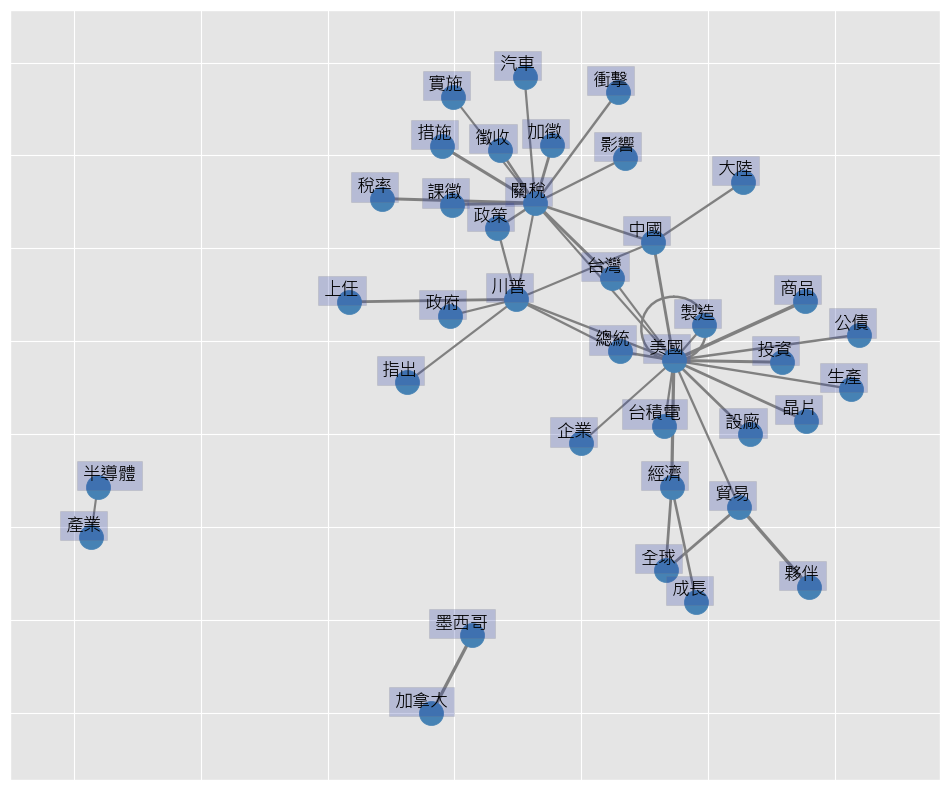

In [105]:
fig, ax = plt.subplots(figsize=(12, 10))
pos = nx.spring_layout(G, k=2, seed=3)

# 畫圖
nx.draw_networkx(G, pos,
                 font_size=16,
                 width=weights,
                 edge_color='gray',
                 node_color='#4682B4',
                 with_labels=False,
                 ax=ax)

# labels：使用 adjustText 避免重疊
texts = []
for key, value in pos.items():
    x, y = value[0], value[1]
    texts.append(ax.text(x, y,
                         s=key,
                         bbox=dict(facecolor='#2C3FA7', edgecolor='gray', alpha=0.25),
                         horizontalalignment='center', fontsize=13))

# 自動調整文字位置，避免重疊
adjust_text(texts, arrowprops=dict(arrowstyle='-', color='black', lw=0.5))

plt.show()

- 除了資料集關鍵字「川普」、「美國」「總統」外，股票版的討論聚焦於「徵收」、「加徵」「關稅」的「政策」。
- 美國、經濟、全球、貿易、夥伴等，表示對川普政策下美國經濟狀況以及其與其他國家貿易關係的關注。
- 「墨西哥」、「加拿大」，是川普自台灣時間 2025/01/21 上任後，關稅政策的第一槍，2025/3/3 宣布對來自兩國的進口商品徵收 25% 的關稅，並於 2025/3/4 生效。2025/3/6 宣布豁免部分商品（不包括所有能源產品）一個月。
- 「中國」、「大陸」、「台灣」、「美國」，表示中美、台美貿易關係、地緣政治的影響成為討論焦點。
- 「台積電」、「半導體」、「產業」、「晶片」、「設廠」，關注台積電赴美設廠、半導體供應鏈重組對股票市場的影響。
- 「經濟」、「成長」、「投資」、「企業」，關注美國經濟政策對整體金融市場或企業投資行為的推動與抑制作用。

#### Trigram

In [33]:
stock_trigram = MetaData.copy()

stock_trigram["word"] = stock_trigram.sentence.apply(lambda row: ngram_getToken(row, 3))
stock_trigram = stock_trigram.explode('word')

stock_trigram.head()

,system_id,artUrl,artTitle,artDate,artContent,sentence,word
0,1,https://www.ptt.cc/bbs/Stock/M.1737417946.A.13...,[新聞]TV面板價揚超大尺寸需求最旺雙虎吞補丸,2025-01-21 08:05:43,原文標題：\nTV 面板價揚 超大尺寸需求最旺 雙虎吞補丸\n\n原文連結：\nhttps:...,原文標題面板價揚超大尺寸需求最旺雙虎吞補丸原文連結發布時間記者署名經濟日報記者李珣瑛新竹報導...,面板 價揚 超大
0,1,https://www.ptt.cc/bbs/Stock/M.1737417946.A.13...,[新聞]TV面板價揚超大尺寸需求最旺雙虎吞補丸,2025-01-21 08:05:43,原文標題：\nTV 面板價揚 超大尺寸需求最旺 雙虎吞補丸\n\n原文連結：\nhttps:...,原文標題面板價揚超大尺寸需求最旺雙虎吞補丸原文連結發布時間記者署名經濟日報記者李珣瑛新竹報導...,價揚 超大 尺寸
0,1,https://www.ptt.cc/bbs/Stock/M.1737417946.A.13...,[新聞]TV面板價揚超大尺寸需求最旺雙虎吞補丸,2025-01-21 08:05:43,原文標題：\nTV 面板價揚 超大尺寸需求最旺 雙虎吞補丸\n\n原文連結：\nhttps:...,原文標題面板價揚超大尺寸需求最旺雙虎吞補丸原文連結發布時間記者署名經濟日報記者李珣瑛新竹報導...,超大 尺寸 需求
0,1,https://www.ptt.cc/bbs/Stock/M.1737417946.A.13...,[新聞]TV面板價揚超大尺寸需求最旺雙虎吞補丸,2025-01-21 08:05:43,原文標題：\nTV 面板價揚 超大尺寸需求最旺 雙虎吞補丸\n\n原文連結：\nhttps:...,原文標題面板價揚超大尺寸需求最旺雙虎吞補丸原文連結發布時間記者署名經濟日報記者李珣瑛新竹報導...,尺寸 需求 最旺
0,1,https://www.ptt.cc/bbs/Stock/M.1737417946.A.13...,[新聞]TV面板價揚超大尺寸需求最旺雙虎吞補丸,2025-01-21 08:05:43,原文標題：\nTV 面板價揚 超大尺寸需求最旺 雙虎吞補丸\n\n原文連結：\nhttps:...,原文標題面板價揚超大尺寸需求最旺雙虎吞補丸原文連結發布時間記者署名經濟日報記者李珣瑛新竹報導...,需求 最旺 雙虎


統計最常出現的 trigram 組合

In [34]:
# 計算每個組合出現的次數
stock_trigram_count = stock_trigram['word'].value_counts().reset_index()

stock_trigram_count.sort_values(['count', 'word'], ascending=False).head(15)

,word,count
0,美國 總統 川普,1107
1,川普 關稅 政策,269
2,總統 川普 關稅,137
3,美國 關稅 政策,87
4,綜合 美國 總統,81
5,美國 貿易 代表,75
6,川普 政府 關稅,60
7,台積電 董事長 魏哲家,58
8,商品 加徵 關稅,54
9,美國 貿易 夥伴,51


- 「台積電 董事長 魏哲家」、「台積電 美國 投資」，顯示使用者高度關注台灣半導體產業在關稅政策下的角色與發展。
- 「費城 半導體 指數」，美股中衡量半導體產業的指數，顯示股票市場關心該產業變化。
- 「知情 人士 透露」，常見於新聞引述來源的用語，增加消息來源的權威性或可信度。

解決問題：原始排序僅根據 `count` 欄位進行，當出現相同次數（如 `count = 47`）時，`index` 的排列順序與實際內容順序不一致。例如，`index = 14` 的「台積電 美國 投資」會排在 `index = 13` 的「國家 主席 習近平」之前。為了解決此情況，增加第二排序欄位 `word`，以確保在 `count` 相同時，依照詞組字典序穩定排序。

### 1.5 Pairwise correlation
計算兩個詞彙間的相關性

In [35]:
data_cor = MetaData.copy()

# 斷詞、去除停用字
data_cor['word'] = data_cor.sentence.apply(getToken).map(' '.join)

data_cor.head()

,system_id,artUrl,artTitle,artDate,artContent,sentence,word
0,1,https://www.ptt.cc/bbs/Stock/M.1737417946.A.13...,[新聞]TV面板價揚超大尺寸需求最旺雙虎吞補丸,2025-01-21 08:05:43,原文標題：\nTV 面板價揚 超大尺寸需求最旺 雙虎吞補丸\n\n原文連結：\nhttps:...,原文標題面板價揚超大尺寸需求最旺雙虎吞補丸原文連結發布時間記者署名經濟日報記者李珣瑛新竹報導...,面板 價揚 超大 尺寸 需求 最旺 雙虎 吞補丸 經濟日報 李珣瑛 新竹 集邦 科技 昨日 ...
1,2,https://www.ptt.cc/bbs/Stock/M.1737419603.A.CC...,[新聞]川普就職演說十重點一次掌握,2025-01-21 08:33:20,原文標題：\n原文連結：\nhttps://udn.com/news/amp/story/1...,原文標題原文連結發布時間記者署名編譯任中原綜合外電原文內容川普周一美國總統就職演說摘錄如下川...,編譯 中原 綜合 外電 川普 周一 美國 總統 就職演說 摘錄 川普 他將 改革 美國 貿易...
2,3,https://www.ptt.cc/bbs/Stock/M.1737424473.A.6C...,[新聞]快訊／川普簽行政命令 宣布美國退出世,2025-01-21 09:54:30,原文標題：\n\n快訊／川普簽行政命令 宣布美國退出世界衛生組織\n原文連結：\nhttps...,原文標題快訊川普簽行政命令宣布美國退出世界衛生組織原文連結發布時間記者署名丘力龍原文內容美國...,快訊 川普 行政命令 美國 退出 世界衛生組織 丘力 美國 當選 總統 川普 台灣 今日 正...
3,4,https://www.ptt.cc/bbs/Stock/M.1737424798.A.8A...,[新聞]川普擬對加拿大、墨西哥「課徵25%關稅」,2025-01-21 09:59:56,川普擬對加拿大、墨西哥「課徵25%關稅」 2月1日生效\nhttps://www.ettod...,川普擬對加拿大墨西哥課徵關稅月日生效新聞雲記者吳美依美國總統川普日中午宣誓就職再度入主白宮成...,川普 擬對 加拿大 墨西哥 課徵 關稅 生效 新聞 吳美依 美國 總統 川普 中午 宣誓就職...
4,5,https://www.ptt.cc/bbs/Stock/M.1737426377.A.E7...,[新聞]川普就職宣布撤銷電動車補助大規模開採,2025-01-21 10:26:14,川普就職宣布撤銷電動車補助 大規模開採石油\nhttps://netzero.cna.com...,川普就職宣布撤銷電動車補助大規模開採石油中央社記者林宏翰美國第位總統川普今天宣誓就職他在就職...,川普 就職 撤銷 電動車 補助 大規模 開採 石油 中央社 林宏翰 美國 第位 總統 川普 ...


In [36]:
# Bag of Word，篩選至少出現在 5 篇文章以上且詞頻前 300 的詞彙
vectorizer = CountVectorizer(min_df = 5, max_features = 300)
X = vectorizer.fit_transform(data_cor["word"])
vocabulary = vectorizer.get_feature_names_out()

# 轉成 dataframe
DTM_df = pd.DataFrame(columns = vocabulary, data = X.toarray())
DTM_df

,一堆,上任,上漲,下跌,下降,不確定性,世界,中國,中心,之間,...,預期,預測,預計,領域,顯示,風險,馬斯克,高達,魏哲家,黃金
0,0,0,1,0,0,1,0,3,0,0,...,3,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,1,1,0,0,...,0,1,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3462,0,0,0,0,0,0,0,3,0,2,...,0,0,0,0,0,0,0,0,0,0
3463,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3464,0,0,0,0,0,0,2,5,0,0,...,0,0,0,0,1,0,0,0,0,0
3465,0,0,0,1,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0


In [37]:
# 計算詞之間的相關係數
corr_matrix = np.corrcoef(DTM_df.T)

# 轉成 dataframe
Cor_df = pd.DataFrame(corr_matrix, index = DTM_df.columns, columns = DTM_df.columns)

Cor_df.insert(0, 'word1', Cor_df.columns)
Cor_df.reset_index(inplace = True, drop = True)

Cor_df

,word1,一堆,上任,上漲,下跌,下降,不確定性,世界,中國,中心,...,預期,預測,預計,領域,顯示,風險,馬斯克,高達,魏哲家,黃金
0,一堆,1.000000,0.006877,-0.033671,-0.040586,0.015110,-0.028444,0.037125,0.002569,-0.022312,...,-0.047952,-0.015546,-0.055965,-0.014745,-0.049427,-0.012837,-0.012645,-0.040168,-0.024302,-0.009397
1,上任,0.006877,1.000000,0.047469,-0.018628,0.031661,0.020316,0.030718,0.032446,0.024844,...,0.037760,-0.015007,0.033419,-0.004829,0.099362,0.048508,0.102879,0.059775,0.010834,-0.007873
2,上漲,-0.033671,0.047469,1.000000,0.245096,0.064334,0.118884,0.020396,0.025663,0.000723,...,0.124644,0.103395,0.104626,0.038206,0.154633,0.051023,0.012953,0.035946,-0.016160,0.089000
3,下跌,-0.040586,-0.018628,0.245096,1.000000,0.096252,0.135169,-0.027228,0.003077,-0.002357,...,0.105846,0.064249,0.020278,-0.000052,0.188173,0.166328,0.045619,0.056459,-0.017957,0.027227
4,下降,0.015110,0.031661,0.064334,0.096252,1.000000,0.096586,0.000619,0.107296,-0.009047,...,0.121392,0.054547,0.059917,0.020800,0.164352,0.121297,0.029562,0.017745,-0.013539,0.011081
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,風險,-0.012837,0.048508,0.051023,0.166328,0.121297,0.199682,0.063828,0.055506,0.029548,...,0.143911,0.106161,0.055354,0.056771,0.174266,1.000000,-0.014286,0.032095,-0.003941,0.045426
296,馬斯克,-0.012645,0.102879,0.012953,0.045619,0.029562,0.016137,0.009630,0.006269,-0.008564,...,-0.003007,-0.008326,-0.004406,0.053277,0.035154,-0.014286,1.000000,0.033978,-0.018514,-0.008319
297,高達,-0.040168,0.059775,0.035946,0.056459,0.017745,-0.006043,-0.008609,0.090206,0.037260,...,0.038879,0.049403,0.057152,0.013201,0.093239,0.032095,0.033978,1.000000,0.027604,-0.006882
298,魏哲家,-0.024302,0.010834,-0.016160,-0.017957,-0.013539,-0.028200,0.011104,-0.035812,0.194585,...,0.000252,-0.015893,0.035008,0.009696,0.003652,-0.003941,-0.018514,0.027604,1.000000,-0.010641


In [38]:
word_cor_df = Cor_df.melt(id_vars = 'word1', var_name = 'word2', value_name = 'cor')

# 去除兩個詞相同的情況
word_cor_df = word_cor_df[word_cor_df["word1"] != word_cor_df["word2"]]

word_cor_df.sort_values('cor', ascending=False).head(10)

,word1,word2,cor
8814,成長,億美元,0.640045
34229,億美元,成長,0.640045
10242,利率,公債,0.607598
12634,公債,利率,0.607598
8704,下降,億美元,0.587241
1229,億美元,下降,0.587241
34204,下降,成長,0.572128
1314,成長,下降,0.572128
88977,特斯拉,馬斯克,0.554596
53396,馬斯克,特斯拉,0.554596


#### 和「特斯拉」、「台積電」相關性最高的 10 個詞彙

In [39]:
tesla_sum = word_cor_df[(word_cor_df["word1"] == "特斯拉")].sort_values(by = ['cor'], ascending = False).head(10)
tsmc_sum = word_cor_df[(word_cor_df["word1"] == "台積電")].sort_values(by = ['cor'], ascending = False).head(10)

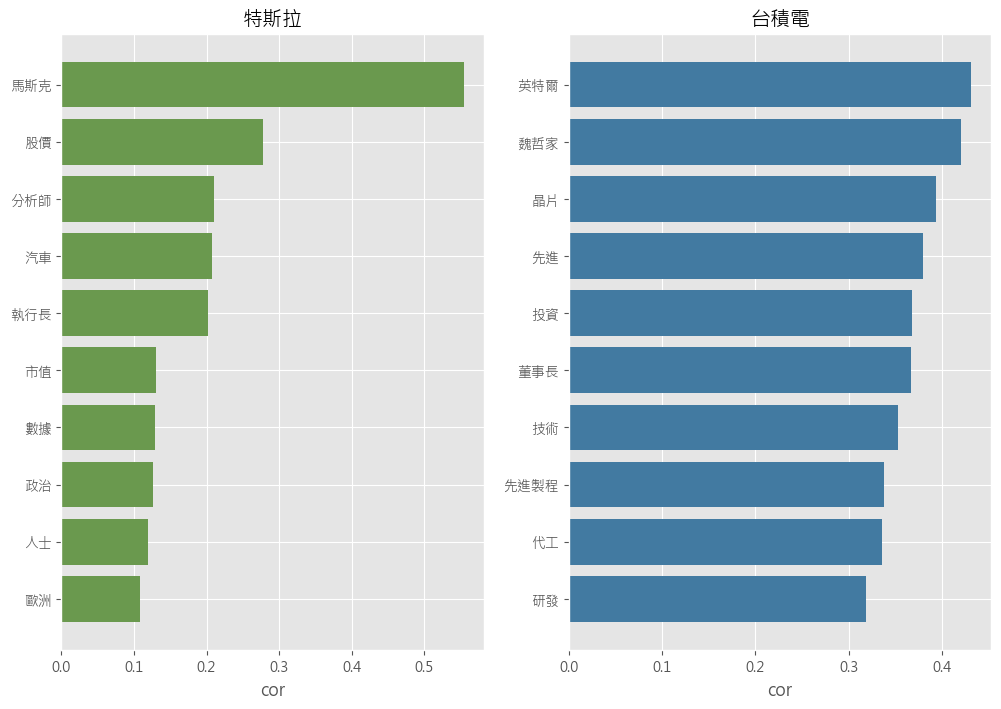

In [40]:
plt.figure(figsize=(12,8))

# 使用 ggplot 主題樣式
plt.style.use("ggplot")

plt.subplot(121)
plt.title('特斯拉')
plt.xlabel('cor')
plt.barh(tesla_sum['word2'],tesla_sum['cor'],color="#6a994e")
plt.gca().invert_yaxis()

plt.subplot(122)
plt.title('台積電')
plt.xlabel('cor')
plt.barh(tsmc_sum['word2'],tsmc_sum['cor'],color="#427aa1")
plt.gca().invert_yaxis()

plt.show()

特斯拉的關鍵詞聚焦在人物（馬斯克）、市場反應（股價）與外部環境（政治）上。
- 馬斯克、執行長：顯示馬斯克作為特斯拉靈魂人物，與公司高度綁定。
- 股價、市值、分析師、數據：呈現投資市場對特斯拉的高度關注。
- 汽車：本業關聯，強調特斯拉作為電動車製造商的角色。
- 政治、人士、歐洲：可能反映國際政策、歐洲市場的影響與討論熱度。

台積電的關聯詞集中在製程技術、研發能力與產業地位上，顯示它在半導體領域的核心角色。
- 英特爾、代工：反映台積電與全球晶片大廠的合作或競爭關係。
- 魏哲家、董事長：人物代表，顯示領導層在產業討論中的可見度。
- 晶片、先進、先進製程、研發、技術：強調台積電的技術實力與創新能力。
- 投資：可能關聯資本支出、海外設廠（如美國、亞利桑那）的議題。

#### 使用詞彙關係圖畫出以詞頻前 50 為節點且相關性高於 0.3 的組合

In [41]:
# 透過 DTM 找出詞頻前 50 高的詞彙
most_freq_df = DTM_df.sum().sort_values(ascending=False).head(50).reset_index().rename(columns={'index':'word', 0:'count'})

most_freq_word = most_freq_df['word'].tolist()

In [42]:
# 保留存在詞頻前 50 高之詞彙的組合
filtered_df = word_cor_df[(word_cor_df['word1'].isin(most_freq_word)) & (word_cor_df['word2'].isin(most_freq_word))]

# 篩選出相關係數大於 0.3 的組合
filtered_df = filtered_df[filtered_df['cor'] > 0.3]
filtered_df.reset_index(inplace=True, drop=True)
filtered_df

,word1,word2,cor
0,指數,下跌,0.379070
1,出口,中國,0.304994
2,美國,中國,0.317112
3,全球,供應鏈,0.306073
4,半導體,供應鏈,0.362371
...,...,...,...
95,政策,關稅,0.331271
96,產品,關稅,0.346581
97,美國,關稅,0.506168
98,課徵,關稅,0.462989


In [43]:
# Create network plot 
g = nx.Graph()

# 建立 nodes 間的連結
for i in range(len(filtered_df)):
    g.add_edge(filtered_df["word1"][i], filtered_df["word2"][i], weight=filtered_df["cor"][i])
    
# 取得 edge 權重
weights = [w[2]['weight']*5 for w in  g.edges(data=True)]

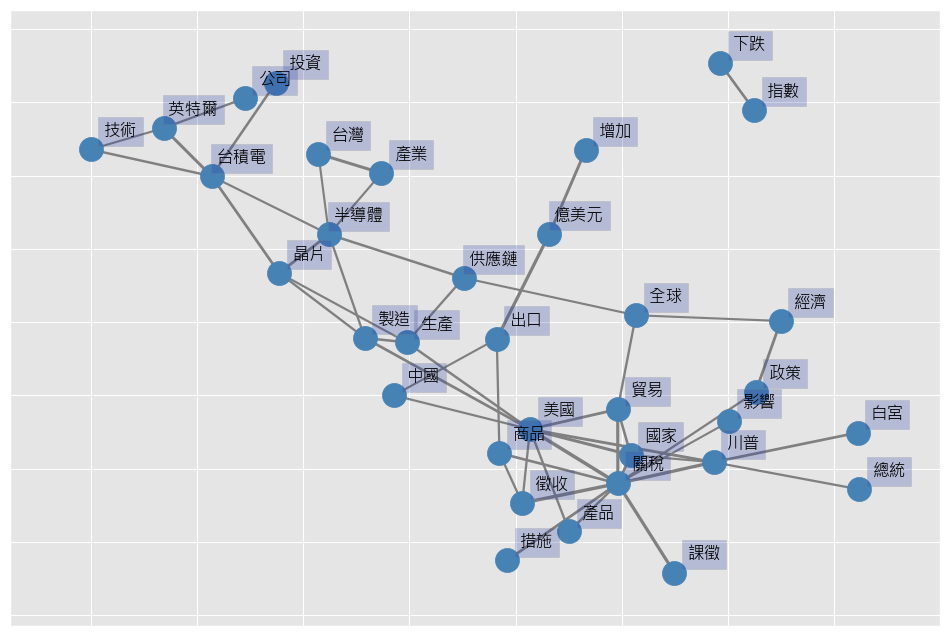

In [44]:
fig, ax = plt.subplots(figsize=(12, 8), facecolor='white')

pos = nx.spring_layout(g, k=0.3)

# networks
nx.draw_networkx(g, pos,
                 font_size=16,
                 width=weights,
                 edge_color='grey',
                 node_color='#4682B4',
                 with_labels = False,
                 ax=ax)

# 增加 labels
for key, value in pos.items():
    x, y = value[0]+.07, value[1]+.045
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='#2C3FA7', edgecolor='gray', alpha=0.25),
            horizontalalignment='center', fontsize=12)

plt.show()

- 美國、台灣、白宮、川普、中國、總統，顯示出這些詞彙可能與國際貿易、外交政策和政治動態有關。
- 關稅、措施、政策、徵收、課徵，強調了貿易政策與稅收的關聯，特別是在國際貿易中可能出現的制裁和經濟制約。
- 半導體、晶片、製造、技術、生產、產業、公司、投資、商品、 供應鏈，顯示出關注半導體產業、科技公司的發展、以及相關技術的成長。
- 台積電、英特爾，特別提到科技巨頭，暗示了關於晶片、半導體領域的競爭和技術發展。
- 經濟、全球、指數、下跌、影響，表明涉及到全球經濟形勢的變動，特別是市場指數和經濟下行壓力。
- 億美元、增加，討論關稅制度下，各國徵收的比例及進出口貿易逆差的相關情形。

### 1.6 計算文章相似度

In [45]:
data_cos = data_cor.copy()
data_cos.head()

,system_id,artUrl,artTitle,artDate,artContent,sentence,word
0,1,https://www.ptt.cc/bbs/Stock/M.1737417946.A.13...,[新聞]TV面板價揚超大尺寸需求最旺雙虎吞補丸,2025-01-21 08:05:43,原文標題：\nTV 面板價揚 超大尺寸需求最旺 雙虎吞補丸\n\n原文連結：\nhttps:...,原文標題面板價揚超大尺寸需求最旺雙虎吞補丸原文連結發布時間記者署名經濟日報記者李珣瑛新竹報導...,面板 價揚 超大 尺寸 需求 最旺 雙虎 吞補丸 經濟日報 李珣瑛 新竹 集邦 科技 昨日 ...
1,2,https://www.ptt.cc/bbs/Stock/M.1737419603.A.CC...,[新聞]川普就職演說十重點一次掌握,2025-01-21 08:33:20,原文標題：\n原文連結：\nhttps://udn.com/news/amp/story/1...,原文標題原文連結發布時間記者署名編譯任中原綜合外電原文內容川普周一美國總統就職演說摘錄如下川...,編譯 中原 綜合 外電 川普 周一 美國 總統 就職演說 摘錄 川普 他將 改革 美國 貿易...
2,3,https://www.ptt.cc/bbs/Stock/M.1737424473.A.6C...,[新聞]快訊／川普簽行政命令 宣布美國退出世,2025-01-21 09:54:30,原文標題：\n\n快訊／川普簽行政命令 宣布美國退出世界衛生組織\n原文連結：\nhttps...,原文標題快訊川普簽行政命令宣布美國退出世界衛生組織原文連結發布時間記者署名丘力龍原文內容美國...,快訊 川普 行政命令 美國 退出 世界衛生組織 丘力 美國 當選 總統 川普 台灣 今日 正...
3,4,https://www.ptt.cc/bbs/Stock/M.1737424798.A.8A...,[新聞]川普擬對加拿大、墨西哥「課徵25%關稅」,2025-01-21 09:59:56,川普擬對加拿大、墨西哥「課徵25%關稅」 2月1日生效\nhttps://www.ettod...,川普擬對加拿大墨西哥課徵關稅月日生效新聞雲記者吳美依美國總統川普日中午宣誓就職再度入主白宮成...,川普 擬對 加拿大 墨西哥 課徵 關稅 生效 新聞 吳美依 美國 總統 川普 中午 宣誓就職...
4,5,https://www.ptt.cc/bbs/Stock/M.1737426377.A.E7...,[新聞]川普就職宣布撤銷電動車補助大規模開採,2025-01-21 10:26:14,川普就職宣布撤銷電動車補助 大規模開採石油\nhttps://netzero.cna.com...,川普就職宣布撤銷電動車補助大規模開採石油中央社記者林宏翰美國第位總統川普今天宣誓就職他在就職...,川普 就職 撤銷 電動車 補助 大規模 開採 石油 中央社 林宏翰 美國 第位 總統 川普 ...


In [46]:
transformer = TfidfTransformer()  
print(transformer) 
# 將詞頻矩陣 X 統計成 TF-IDF 值
tfidf = transformer.fit_transform(X)  

# 轉成 dataframe
TFIDF_df = pd.DataFrame(columns = vocabulary, data = tfidf.toarray())
TFIDF_df

TfidfTransformer()


,一堆,上任,上漲,下跌,下降,不確定性,世界,中國,中心,之間,...,預期,預測,預計,領域,顯示,風險,馬斯克,高達,魏哲家,黃金
0,0.0,0.000000,0.051644,0.000000,0.0,0.052103,0.000000,0.087809,0.0,0.000000,...,0.131724,0.00000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000
1,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.133338,0.088150,0.0,0.000000,...,0.000000,0.16174,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000
2,0.0,0.379297,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.00000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000
3,0.0,0.111519,0.000000,0.000000,0.0,0.000000,0.000000,0.120518,0.0,0.000000,...,0.000000,0.00000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000
4,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.00000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.133791
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3462,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.224331,0.0,0.287105,...,0.000000,0.00000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000
3463,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.199370,0.0,0.000000,...,0.000000,0.00000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000
3464,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.140848,0.232788,0.0,0.000000,...,0.000000,0.00000,0.000000,0.0,0.076532,0.0,0.0,0.0,0.0,0.000000
3465,0.0,0.000000,0.000000,0.095927,0.0,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.00000,0.105802,0.0,0.101101,0.0,0.0,0.0,0.0,0.000000


In [47]:
cosine_matrix = cosine_similarity(tfidf.toarray(), tfidf.toarray())

In [48]:
cos_df = pd.DataFrame(cosine_matrix[0], columns = ['cos_similarity'])
cos_df

,cos_similarity
0,1.000000
1,0.037527
2,0.020777
3,0.050122
4,0.087444
...,...
3462,0.038165
3463,0.057867
3464,0.117287
3465,0.165541


In [49]:
cos_df = cos_df.merge(data_cos, how = 'left', left_index=True, right_index=True)
cos_df.loc[:,["cos_similarity", "artTitle", "artUrl"]].sort_values(by=['cos_similarity'], ascending=False).head(10)

,cos_similarity,artTitle,artUrl
0,1.000000,[新聞]TV面板價揚超大尺寸需求最旺雙虎吞補丸,https://www.ptt.cc/bbs/Stock/M.1737417946.A.13...
189,0.689754,Re:[爆卦]川普2/18起徵收晶片關稅,https://www.ptt.cc/bbs/Stock/M.1738399337.A.6D...
386,0.579162,[新聞]大摩按讚群創、聯詠,https://www.ptt.cc/bbs/Stock/M.1738888834.A.6C...
1471,0.561095,[新聞]記憶體迎春天美光宣布漲價,https://www.ptt.cc/bbs/Stock/M.1743040260.A.4E...
1958,0.539998,[新聞]憂高關稅先囤貨！ 三星電子傳調漲記憶體,https://www.ptt.cc/bbs/Stock/M.1743789079.A.E0...
1150,0.536257,[新聞]中鋼目標價30元！,https://www.ptt.cc/bbs/Stock/M.1741605777.A.6D...
2279,0.536115,Re:[請益]川普意圖根本不在解決經濟而是國債怎辦?,https://www.ptt.cc/bbs/Stock/M.1743994854.A.15...
2325,0.533993,Re:[心得]美國最終還是會贏,https://www.ptt.cc/bbs/Stock/M.1744007008.A.B7...
674,0.511400,[新聞]TV面板報價逆勢漲不停全尺寸勁揚群創直言「對台廠有利」,https://www.ptt.cc/bbs/Stock/M.1739920007.A.0C...
495,0.481570,[新聞]美國雞蛋價格持續飆升再創歷史新高並推升CPI數據,https://www.ptt.cc/bbs/Stock/M.1739438788.A.BF...


### 1.7 建立 Ngram 預測模型

In [50]:
predict = MetaData.copy()
sen_tokens = predict.sentence.apply(getToken).tolist()

In [51]:
def ngram(documents, N=2):
    ngram_prediction = dict()
    total_grams = list()
    words = list()
    Word = namedtuple('Word', ['word', 'prob'])

    for doc in documents:
        # 加上開頭和結尾 tag
        split_words = ['<s>'] + list(doc) + ['</s>']
        # 計算分子
        [total_grams.append(tuple(split_words[i:i+N])) for i in range(len(split_words)-N+1)]
        # 計算分母
        [words.append(tuple(split_words[i:i+N-1])) for i in range(len(split_words)-N+2)]
        
    total_word_counter = Counter(total_grams)
    word_counter = Counter(words)
    
    for key in total_word_counter:
        word = ''.join(key[:N-1])
        if word not in ngram_prediction:
            ngram_prediction.update({word: set()})
            
        next_word_prob = total_word_counter[key]/word_counter[key[:N-1]] #P(B|A)
        w = Word(key[-1], '{:.3g}'.format(next_word_prob))
        ngram_prediction[word].add(w)
        
    return ngram_prediction

In [52]:
# Bigram 預測模型為例
bi_prediction = ngram(sen_tokens, N=2)

In [53]:
text = '總統'
next_words = list(bi_prediction[text])
next_words.sort(key = lambda s: s[1], reverse = True)
for next_word in next_words[:5]:
    print('next word: {}, probability: {}'.format(next_word.word, next_word.prob))

next word: 川普, probability: 0.494
next word: 賴清德, probability: 0.0247
next word: 拜登, probability: 0.0162
next word: 澤倫斯基, probability: 0.0145
next word: 關稅, probability: 0.0132


In [54]:
text = '美債'
next_words = list(bi_prediction[text])
next_words.sort(key = lambda s: s[1], reverse = True)
for next_word in next_words[:5]:
    print('next word: {}, probability: {}'.format(next_word.word, next_word.prob))

next word: 市場, probability: 0.0339
next word: 利息, probability: 0.031
next word: 拋售, probability: 0.0268
next word: 違約, probability: 0.024
next word: 美國, probability: 0.0212


# 2. 文件分類

主要使用文章轉DTM(document term matrix)的方式，將文章用不同的字詞分布表示，再利用python的sklearn套件，套用決策樹、logistic regression等方式訓練模型，以分辨不同的文件。本篇 Jupyter Notebook 將展示「中文」的文件分類，使用聯合新聞網的四個版別文章做示範進行分類器訓練和評估，最後在用以訓練好的分類器對PTT股票版的文章進行分類器。

**分析目標**
+ 資料內容：
    + 資料來源：聯合新聞網
    + 版別：要聞、股市、產經、全球

* 分析主題：將聯合新聞網四個版別的文章合起來，訓練模型能預測新聞版別，再用分類模型進行文件的版別分類。

### 2.1 載入套件

In [55]:
import re
from pprint import pprint

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import jieba
from sklearn.model_selection import train_test_split, cross_validate, cross_val_predict, KFold
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_curve,
    auc,
    precision_recall_curve,
    RocCurveDisplay
)
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import LabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm

In [56]:
# 使圖中中文能正常顯示
# plt.rcParams['font.sans-serif'] = ['Arial Unicode Ms'] # MacOS
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']

# 使負號能夠顯示 
plt.rcParams['axes.unicode_minus'] = False

### 2.2 文字前處理
`udn3.csv` 裡面包含了要分析的 udn 新聞資料。
- 版別：要聞、股市、產經、全球
- 時間範圍：2025/02/20 ~ 2025/03/20
- 工作流程平台搜尋/排除關鍵字：無

In [57]:
# 匯入資料
udn = pd.read_csv("raw_data/udn3.csv")
udn.head(3)

,system_id,artTitle,artDate,artCatagory,artUrl,artContent,artSecondCategory,dataSource,artSecondCatagory
0,1,美退將籲美台加強聯訓合作 發揮「2+2=5」戰力,2025-02-21 21:58:00,要聞,https://udn.com/news/story/10930/8563859,美國海軍退役少將蒙哥馬利今天表示，由於美台兩軍現在沒有充分的整合與協調，目前美台的聯合戰力有...,NaN,UDN,NaN
1,2,我國防預算目標達GDP3%以上 黃仁：台灣安全與外交政策方向錯誤,2025-02-22 18:51:00,要聞,https://udn.com/news/story/10930/8565217,賴清德總統日前舉行國安高層會議，會後表示將優先編列特別預算，讓國防預算達到GDP3%以上。國...,NaN,UDN,NaN
2,3,美軍少將參與漢光兵推？ 專家：有前例可平常心看待,2025-02-22 19:33:00,要聞,https://udn.com/news/story/10930/8565244,國防部長顧立雄視導漢光演習圖上兵推，卻被發現身旁座位出現美國印太司令部聯五少將的名牌。國防院...,NaN,UDN,NaN


In [58]:
# 看看有幾篇文章
print(f"number of posts: {udn.shape[0]}")
print(f"date range: {(udn['artDate'].min(), udn['artDate'].max())}")
print(f"category: \n{udn['artCatagory'].value_counts()}")

number of posts: 5829
date range: ('2025-02-20 00:13:00', '2025-03-20 23:25:00')
category: 
artCatagory
全球    4194
股市     723
產經     648
要聞     264
Name: count, dtype: int64


#### 2.2.1 斷句
利用問號、句號或驚嘆號等符號斷句，或是如果出現中文或是英文的省略號，像是 `...` 也會斷句，最後設定會去除結尾的空白符號。

In [59]:
# 設定繁體中文詞庫
jieba.set_dictionary("./dict/dict.txt.big")

# 新增 stopwords
with open("./dict/stop_words.txt", encoding="utf-8") as f:
    stopWords = [line.strip() for line in f.readlines()]

In [60]:
# 過濾 nan 的資料
udn = udn.dropna(subset=['artTitle'])
udn = udn.dropna(subset=['artContent'])
# 移除網址格式
udn["artContent"] = udn.artContent.apply(
    lambda x: re.sub("(http|https)://.*", "", x)
)
udn["artTitle"] = udn["artTitle"].apply(
    lambda x: re.sub("(http|https)://.*", "", x)
)
 #載入或定義停用字清單（含手動加的）
stopwords_manual = ["川普"]
stopWords.extend(stopwords_manual)  # 將手動加入的詞納入停用字
# 只留下中文字
udn["artContent"] = udn.artContent.apply(
    lambda x: re.sub("[^\u4e00-\u9fa5]+", "", x)
)
udn["artTitle"] = udn["artTitle"].apply(
    lambda x: re.sub("[^\u4e00-\u9fa5]+", "", x)
)

udn.head(3)

,system_id,artTitle,artDate,artCatagory,artUrl,artContent,artSecondCategory,dataSource,artSecondCatagory
0,1,美退將籲美台加強聯訓合作發揮戰力,2025-02-21 21:58:00,要聞,https://udn.com/news/story/10930/8563859,美國海軍退役少將蒙哥馬利今天表示由於美台兩軍現在沒有充分的整合與協調目前美台的聯合戰力有如雙...,NaN,UDN,NaN
1,2,我國防預算目標達以上黃仁台灣安全與外交政策方向錯誤,2025-02-22 18:51:00,要聞,https://udn.com/news/story/10930/8565217,賴清德總統日前舉行國安高層會議會後表示將優先編列特別預算讓國防預算達到以上國民黨立委黃仁今天...,NaN,UDN,NaN
2,3,美軍少將參與漢光兵推專家有前例可平常心看待,2025-02-22 19:33:00,要聞,https://udn.com/news/story/10930/8565244,國防部長顧立雄視導漢光演習圖上兵推卻被發現身旁座位出現美國印太司令部聯五少將的名牌國防院戰略...,NaN,UDN,NaN


文章的標題 `artTitle` 和內文 `sentence` 都會納入分析的內容，成為新的 `content` 欄位。

In [61]:
# 留下 content
udn["content"] = udn["artTitle"] + udn["artContent"]
udn = udn[["content", "artUrl", "artCatagory"]]  # 文章內容 文章連結
udn.head()

,content,artUrl,artCatagory
0,美退將籲美台加強聯訓合作發揮戰力美國海軍退役少將蒙哥馬利今天表示由於美台兩軍現在沒有充分的整...,https://udn.com/news/story/10930/8563859,要聞
1,我國防預算目標達以上黃仁台灣安全與外交政策方向錯誤賴清德總統日前舉行國安高層會議會後表示將優...,https://udn.com/news/story/10930/8565217,要聞
2,美軍少將參與漢光兵推專家有前例可平常心看待國防部長顧立雄視導漢光演習圖上兵推卻被發現身旁座位...,https://udn.com/news/story/10930/8565244,要聞
3,美解凍對台軍援學者台灣安全是川普對中戰略重點路透社報導美國總統川普政府釋出先前凍結的億美元外...,https://udn.com/news/story/10930/8565329,要聞
4,美學者軍援台灣應設條件促提高國防支出與改革兩名美國學者今天發表專文建議美國總統川普將對台灣的...,https://udn.com/news/story/10930/8571966,要聞


In [62]:
# 看看有幾篇文章
print(f"total docs: {udn.shape[0]}")

total docs: 5829


#### 2.2.2 斷詞
刪掉次數太少的、標點符號、停用字

In [72]:
# 設定斷詞 function
def getToken(row):
    seg_list = jieba.cut(row, cut_all=False)
    seg_list = [
        w for w in seg_list if w not in stopWords and len(w) > 1
    ]  # 篩選掉停用字與字元數大於 1 的詞彙
    return seg_list

In [74]:
udn["words"] = udn["content"].apply(getToken).map(" ".join)
udn.head()

,content,artUrl,artCatagory,words
0,美退將籲美台加強聯訓合作發揮戰力美國海軍退役少將蒙哥馬利今天表示由於美台兩軍現在沒有充分的整...,https://udn.com/news/story/10930/8563859,要聞,美退 將籲 美台 加強 聯訓 合作 發揮 戰力 美國 海軍 退役 少將 蒙哥馬利 今天 表示...
1,我國防預算目標達以上黃仁台灣安全與外交政策方向錯誤賴清德總統日前舉行國安高層會議會後表示將優...,https://udn.com/news/story/10930/8565217,要聞,國防 預算 目標 達以 上黃 仁台灣 安全 外交政策 方向 錯誤 賴清德 總統 日前 舉行 ...
2,美軍少將參與漢光兵推專家有前例可平常心看待國防部長顧立雄視導漢光演習圖上兵推卻被發現身旁座位...,https://udn.com/news/story/10930/8565244,要聞,美軍 少將 參與 漢光 專家 前例 平常心 看待 國防部長 顧立 雄視 漢光 演習 圖上 推...
3,美解凍對台軍援學者台灣安全是川普對中戰略重點路透社報導美國總統川普政府釋出先前凍結的億美元外...,https://udn.com/news/story/10930/8565329,要聞,解凍 對台 軍援 學者 台灣 安全 普對 戰略重點 路透社 報導 美國 總統 政府 釋出 先...
4,美學者軍援台灣應設條件促提高國防支出與改革兩名美國學者今天發表專文建議美國總統川普將對台灣的...,https://udn.com/news/story/10930/8571966,要聞,學者 軍援 台灣 應設 條件 提高 國防 支出 改革 兩名 美國 學者 今天 發表 專文 建...


#### 2.2.3 資料集基本檢視

In [75]:
# 檢視資料內容
print(f"total posts: {len(udn['artUrl'].unique())}")
print(f"category: \n{udn['artCatagory'].value_counts()}")

total posts: 5829
category: 
artCatagory
全球    4194
股市     723
產經     648
要聞     264
Name: count, dtype: int64


### 2.3 分類模型的訓練流程
#### 2.3.1 根據 7:3 的比例切分資料集
利用 sklearn 中的 train_test_split 函數將 `raw_data` 隨機切成 7:3，設置 random_state 讓每次切分的結果一致。`y_train` 和 `y_test` 分別為訓練資料和測試資料的預測目標。

In [76]:
data = udn
X = data["words"]
y = data["artCatagory"]

# 把整個資料集七三切
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=666
)

print(X_train.head())
print(y_train.head())

1612    開羅 重啟 談判 商討 以色列 哈瑪斯 階段 停火 加薩 衝突 有望 落幕 各方 今天 埃及...
4081    政府 削減 支出 考慮 關閉 部分 美國 駐外 領事館 數名 美國 官員 今天 表示 美國國...
1059    關稅 將來 襲美 貿易逆差 亞太 第三台 危險 貿易逆差 美國 總統 一大 經濟 煩惱 美國...
1622    聯合國 重金 保護 生態系 全球 超過 國家 同意 年前 每年 撥出 億美元 用於 逆轉 失...
652     仰賴 星鏈 提供 戰場 情報 暫停 軍援 相關 影響 一次 兩名 白宮 官員 表示 美國 總...
Name: words, dtype: object
1612    全球
4081    全球
1059    全球
1622    全球
652     全球
Name: artCatagory, dtype: object


In [77]:
# 看一下各個資料集切分的比例，應該要一致
print(
    f"raw data percentage :\n{data['artCatagory'].value_counts(normalize=True) * 100}"
)
print(f"\ntrain percentage :\n{y_train.value_counts(normalize=True) * 100}")
print(f"\ntest percentage :\n{y_test.value_counts(normalize=True) * 100}")

raw data percentage :
artCatagory
全球    71.950592
股市    12.403500
產經    11.116830
要聞     4.529079
Name: proportion, dtype: float64

train percentage :
artCatagory
全球    72.156863
股市    11.985294
產經    11.495098
要聞     4.362745
Name: proportion, dtype: float64

test percentage :
artCatagory
全球    71.469411
股市    13.379074
產經    10.234420
要聞     4.917095
Name: proportion, dtype: float64


#### 2.3.2 定義模型訓練組合
為讓模型評估能夠更穩定 cross-validation 

In [78]:
# 定義模型訓練組合
## pipeline: 資料處理 vectorizer + 分類器 clf
## 由於 cross-validation 會自動將資料分成 train/test，因此 input 只要給 X, y 即可

def train_cv(vectorizer, clf, X, y):

    ## train classifier
    vec_X = vectorizer.fit_transform(X).toarray()
    
    ## get cv results
    cv_results = cross_validate(clf, vec_X, y, cv=5, return_estimator=True)
    y_pred = cross_val_predict(clf, vec_X, y, cv=5)
    y_pred_proba = cross_val_predict(clf, vec_X, y, cv=5, method="predict_proba")
    
    ## Accuracy, Precision, Recall, F1-score
    cls_report = classification_report(y, y_pred, output_dict=True)
    print(classification_report(y, y_pred))

    classes = cv_results['estimator'][0].classes_
    
    ## Plot confusion matrix
    cm = confusion_matrix(y, y_pred)
    fig, ax = plt.subplots()
    sns.heatmap(cm, annot=True, fmt="d", ax=ax, cmap=plt.cm.Blues, cbar=False)
    ax.set(
        xlabel="Pred",
        ylabel="True",
        xticklabels=classes,
        yticklabels=classes,
        title= str(clf) + "Confusion matrix",
    )
    plt.yticks(rotation=0)

    clf.fit(vec_X, y)
    # return the model object
    return cls_report

              precision    recall  f1-score   support

          全球       0.96      0.99      0.98      2944
          產經       0.86      0.76      0.81       469
          股市       0.89      0.90      0.89       489
          要聞       0.84      0.62      0.72       178

    accuracy                           0.94      4080
   macro avg       0.89      0.82      0.85      4080
weighted avg       0.94      0.94      0.94      4080



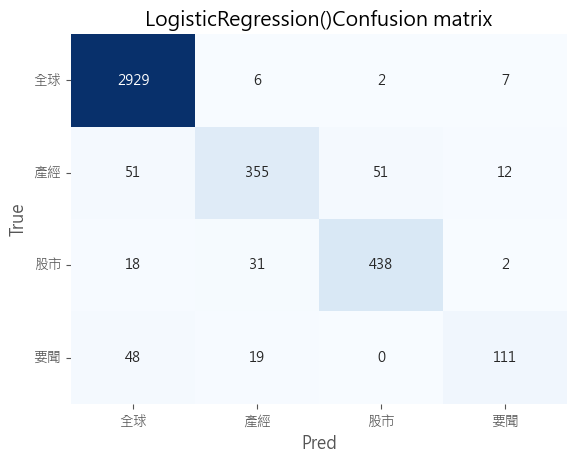

In [79]:
# 先用 LogisticRegression，測試 function 能不能跑
vectorizer = TfidfVectorizer(max_features=1000)
clf = LogisticRegression()
result = train_cv(vectorizer, clf, X_train, y_train)

 類別不平衡（class imbalance）問題，會讓模型對「多數類別」過度偏好，而忽略了少數類別（例如這裡的「要聞」和「產經」）。

 調整樣本權重 `class_weight='balanced'`，會根據樣本數自動調整：

              precision    recall  f1-score   support

          全球       0.99      0.97      0.98      2944
          產經       0.83      0.81      0.82       469
          股市       0.88      0.92      0.90       489
          要聞       0.68      0.88      0.76       178

    accuracy                           0.94      4080
   macro avg       0.85      0.89      0.87      4080
weighted avg       0.95      0.94      0.94      4080



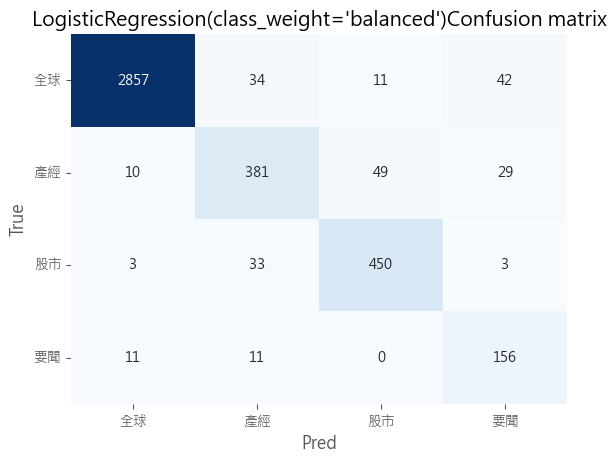

In [80]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

# 建立向量器（TF-IDF，最多 1000 個詞）
vectorizer = TfidfVectorizer(max_features=1000)

# 加入 class_weight='balanced' 的分類器
clf = LogisticRegression(class_weight='balanced')

# 呼叫你的交叉驗證訓練函式（假設你已經有定義好的 train_cv）
result2 = train_cv(vectorizer, clf, X_train, y_train)

平衡後：
加上 `class_weight='balanced'` 的結果，在整體分類效果上對少數類別明顯比較好
像是 `macro avg` 是各類別平均，不考慮樣本比例，更能反映少數類別的效果！平衡後表現更好

在產經 / 要聞 皆有顯著 `recall` 提升

#### 2.3.3 比較不同模型效果

now training: clf_logistic
              precision    recall  f1-score   support

          全球       0.99      0.97      0.98      2944
          產經       0.83      0.81      0.82       469
          股市       0.88      0.92      0.90       489
          要聞       0.68      0.88      0.76       178

    accuracy                           0.94      4080
   macro avg       0.85      0.89      0.87      4080
weighted avg       0.95      0.94      0.94      4080

now training: clf_dtree
              precision    recall  f1-score   support

          全球       0.97      0.97      0.97      2944
          產經       0.74      0.75      0.75       469
          股市       0.85      0.81      0.83       489
          要聞       0.64      0.63      0.64       178

    accuracy                           0.91      4080
   macro avg       0.80      0.79      0.80      4080
weighted avg       0.91      0.91      0.91      4080

now training: clf_svm
              precision    recall  f1-score   support

  

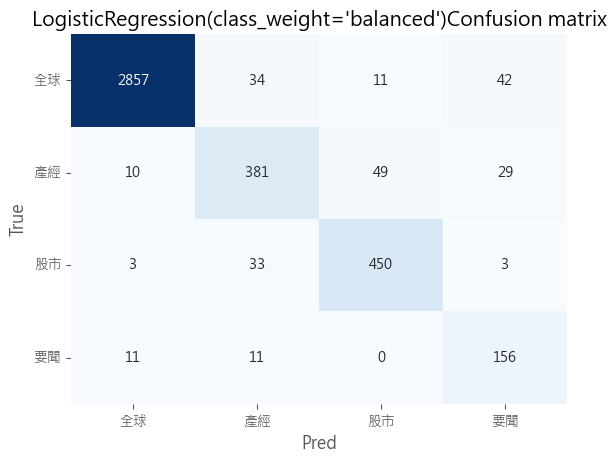

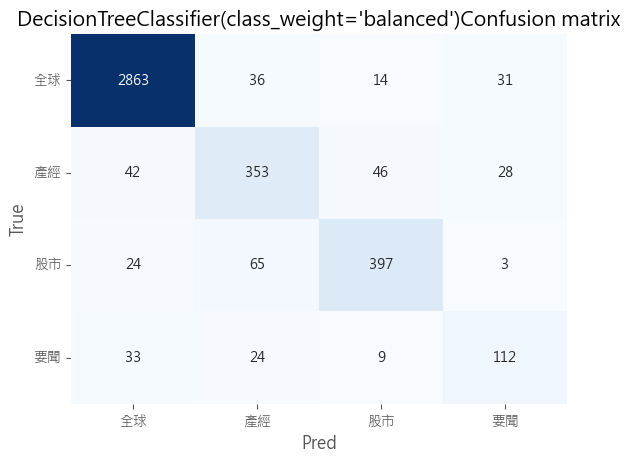

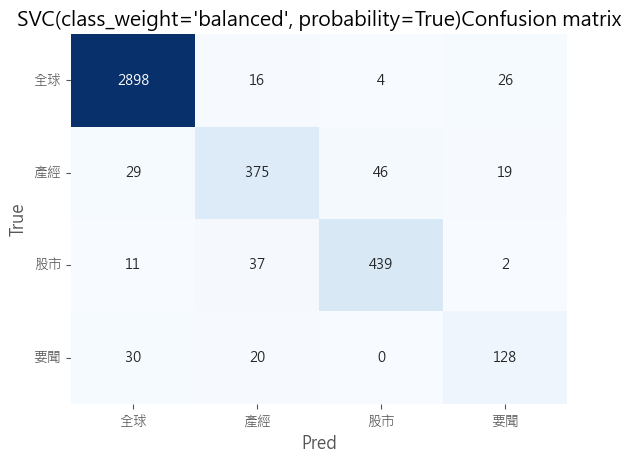

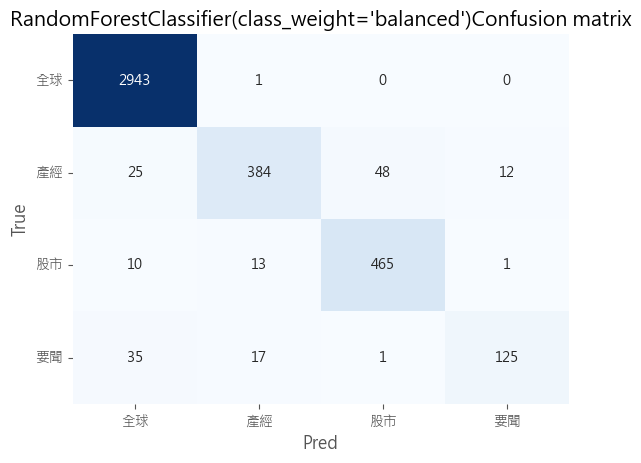

In [81]:
# 準備訓練資料
X = data["words"]
y = data["artCatagory"]

# 把整個資料集七三切
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=666
)
# 定義模型訓練組合（有平衡）
model_set = dict()
model_set['clf_logistic'] = LogisticRegression(class_weight='balanced')
model_set['clf_dtree'] = DecisionTreeClassifier(class_weight='balanced')
model_set['clf_svm'] = svm.SVC(probability=True, class_weight='balanced')
model_set['clf_rf'] = RandomForestClassifier(class_weight='balanced')
# 定義 vectorizer
vectorizer = TfidfVectorizer(max_features=1000)
# 存結果
result_set = dict()

for k, model in model_set.items():
    print("="*100)
    print(f"now training: {k}")
    result_set[k] = train_cv(vectorizer, model, X_train, y_train)
    print("="*100)

+ 找出 `f1-score` 表現最好的模型是哪個，作為我們最終得到的分類器

In [82]:
max = 0
best_model_name = ""
best_model_metric = "f1-score"

## choose max f1-score model from result_set
for k, v in result_set.items():
    if v['weighted avg'][best_model_metric] > max:
        max = v['weighted avg'][best_model_metric]
        best_model_name = k
print(f"best model: {best_model_name}")
pprint(result_set[best_model_name])

best model: clf_rf
{'accuracy': 0.9600490196078432,
 'macro avg': {'f1-score': 0.8938042787413085,
               'precision': 0.9281337271222553,
               'recall': 0.8678977721807446,
               'support': 4080.0},
 'weighted avg': {'f1-score': 0.9584805798980196,
                  'precision': 0.9591138409401511,
                  'recall': 0.9600490196078432,
                  'support': 4080.0},
 '全球': {'f1-score': 0.9880812489508142,
        'precision': 0.9767673415200796,
        'recall': 0.9996603260869565,
        'support': 2944.0},
 '產經': {'f1-score': 0.8687782805429864,
        'precision': 0.9253012048192771,
        'recall': 0.8187633262260128,
        'support': 469.0},
 '股市': {'f1-score': 0.9272183449651047,
        'precision': 0.9046692607003891,
        'recall': 0.950920245398773,
        'support': 489.0},
 '要聞': {'f1-score': 0.7911392405063291,
        'precision': 0.9057971014492754,
        'recall': 0.702247191011236,
        'support': 178.0}}


表現最好的是 `RandomForestClassifier`

In [83]:
y_pred = model_set['clf_rf'].predict(vectorizer.transform(X_test).toarray())
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          全球       0.99      1.00      0.99      1250
          產經       0.90      0.85      0.88       179
          股市       0.93      0.96      0.95       234
          要聞       0.96      0.79      0.87        86

    accuracy                           0.97      1749
   macro avg       0.94      0.90      0.92      1749
weighted avg       0.97      0.97      0.97      1749



In [84]:
model_set['clf_rf'].predict(vectorizer.transform(["台積電 股票 大學教授"]).toarray())

array(['產經'], dtype=object)

* 最佳的 model 為 SVM，其中 Decision Tree 的表現較差外，其餘三個 model （Logistic、SVM、Random Forest）表現差不多。
* 另外也可以嘗試用直接的詞頻表作為 `vectorizer`，比較看看相較 tfidf，是否效果更好。

### 2.4 分析可解釋模型的結果
#### 2.4.1 各字詞特徵的迴歸係數
對於線性的模型，可以藉由相關係數，查看資料特徵（詞）對於判斷分類的影響
+ 迴歸係數（coefficient estimates）反映了每個特徵對預測結果的影響程度和方向。​當其他變數保持不變時，某一特徵的值增加一個單位（例如詞頻增加1），其對應的迴歸係數表示該特徵對事件發生機率的影響。
+ 計算後得到勝算比（odds ratio），這表示該特徵每增加一個單位，事件發生的勝算（odds）相對於未增加時的倍數變化。
+ 這裡舉 logistic regression + cv tokenizer 為例

In [85]:
def plot_coef(logistic_reg_model, feature_names, top_n=10):
    # 選出某個類別的前 10 大影響力字詞
    log_odds = logistic_reg_model.coef_.T
    coef_df = pd.DataFrame(
        log_odds, 
        columns=logistic_reg_model.classes_, index=feature_names
    )
    for label in coef_df.columns:
        select_words = (
            coef_df[[label]]
            .sort_values(by=label, ascending=False)
            .iloc[np.r_[0:top_n, -top_n:0]]
        )
        word = select_words.index
        count = select_words[label]
        category_colors = np.where(
            select_words[label] >= 0, "darkseagreen", "rosybrown"
        )  # 設定顏色

        fig, ax = plt.subplots(figsize=(8, top_n*0.8))  # 設定畫布
        plt.rcParams["axes.unicode_minus"] = False

        ax.barh(word, count, color=category_colors)
        ax.invert_yaxis()
        ax.set_title(
            "Coeff increase/decrease odds ratio of 「" + label + "」 label the most",
            loc="left",
            size=16,
        )
        ax.set_ylabel("word", size=14)
        ax.set_xlabel("odds ratio", size=14)

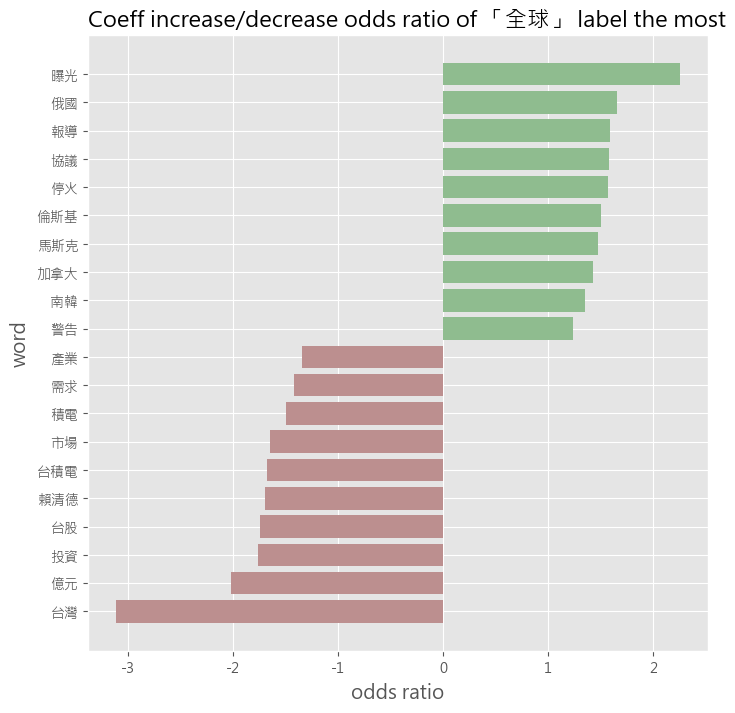

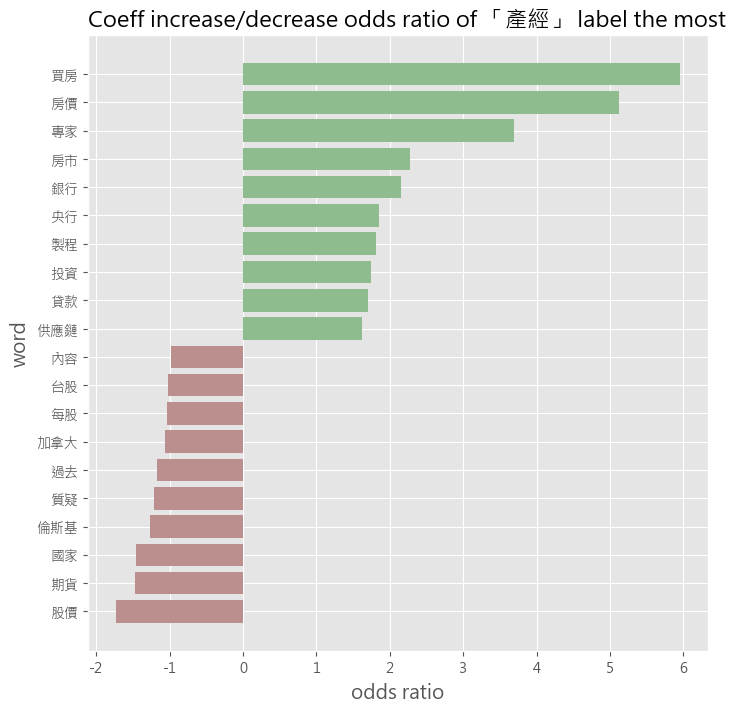

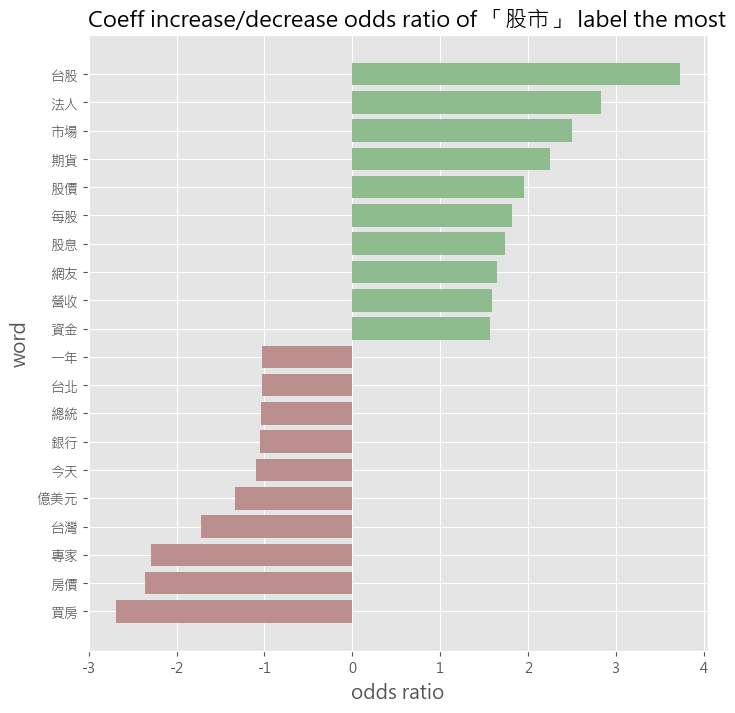

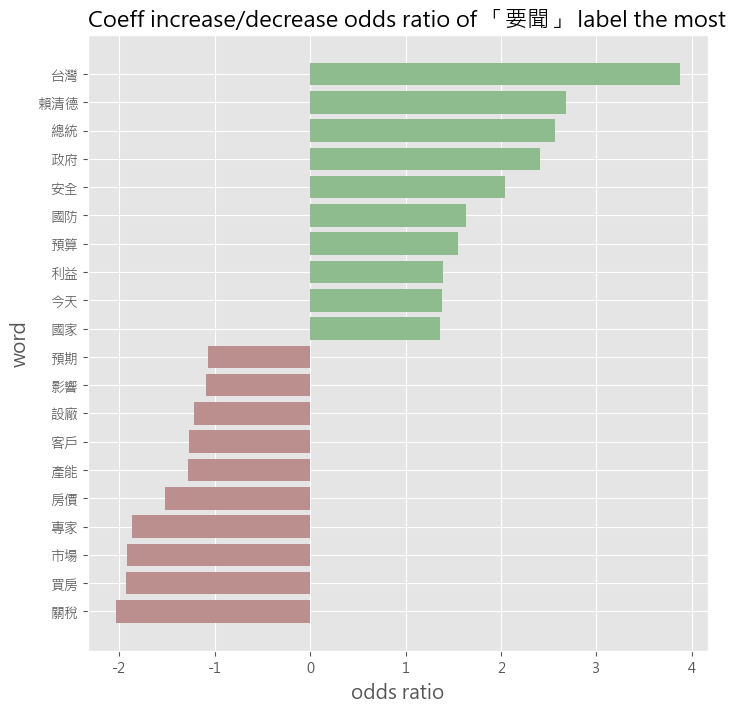

In [86]:
plot_coef(logistic_reg_model=model_set['clf_logistic'], feature_names=vectorizer.get_feature_names_out(), top_n=10)

主題詞解釋：
【全球】
正向詞：像是「曝光」、「川普」、「俄國」、「停火」、「報導」、「馬斯克」等，這些字詞常見於國際新聞與地緣政治報導中。顯示「全球」類文章涵蓋許多國際人物、國際衝突、重大政治事件。
負向詞：「台灣」、「億元」、「投資」、「台股」、「鴻海」等明顯偏向本地財經議題。

【產經】
正向詞：「買房」、「房價」、「專家」、「房市」、「央行」、「貸款」、「投資」、「製程」等詞，圍繞在房市動態、經濟政策、製造業等核心議題。
「川普」、「加拿大」、「國家」、「股價」、「期貨」等，這些字詞雖與宏觀經濟或政治相關，但多出現在「全球」、「股市」類。

【股市】
正向詞：「台股」、「法人」、「股價」、「每股」、「漲幅」、「營收」、「股息」、「網友」等，屬於台灣金融市場專有詞彙。
「法人」、「網友」反映報導中常見散戶與法人買賣分析。

【要聞】主題詞解釋：
正向詞：

「台灣」、「賴清德」、「總統」、「政府」、「安全」、「國防」、「預算」、「今天」、「利益」等，明顯與內政、政府與政治新聞相關。

### 2.5 用訓練好的分類器來預測其他家的新聞類別
我們前面使用聯合新聞網的資料訓練好了分類器模型，接著用其他家新聞網的資料試試看分類的效果。

`ebc.csv` 為東森新聞網資料
- 版別：社會、財經、國際、政治、兩岸
- 時間範圍：2025/02/20 ~ 2025/03/30
- 工作流程平台搜尋/排除關鍵字：無（如設定關鍵字資料太少）

In [87]:
# 匯入資料
ct = pd.read_csv("./raw_data/ebc.csv")
ct.dropna(inplace=True)
ct

,system_id,artTitle,artUrl,artDate,artCatagory,artContent,dataSource
0,1,iPhone 16e登場！「最平價AI手機」亮點規格、售價一次看,https://news.ebc.net.tw/news/business/472572,2025-02-20 07:00:00,財經,蘋果今（20）日凌晨進行春季發布會，帶來iPhone 16家族新成員iPhone 16e，搭...,EBC
1,2,台積電挫20元 台股跌逾170點 工業電腦逆勢走揚,https://news.ebc.net.tw/news/business/472599,2025-02-20 09:33:00,財經,台股今（20）日早盤開低震盪，最低下探23429點，跌逾170點，回測10日線，預估成交量僅...,EBC
2,3,東森深度周報／台灣女婿操刀 健身龍頭吃下美國品牌,https://news.ebc.net.tw/news/business/472661,2025-02-21 06:00:00,財經,根據最新統計，有規律運動的台灣人口創下新高，每3個人中就有1人，這也讓「汗水商機」跟著大爆發...,EBC
3,4,汽車大廠保時捷爆裁員！1900人恐受影響 原因曝光,https://news.ebc.net.tw/news/business/472769,2025-02-20 22:47:00,財經,大多數人都希望自己能有份安穩的工作，若是無預警遭到資遣，可能會造成員工心裡的不安與不滿。汽車...,EBC
4,5,才剛退休！老牌科技大廠董座傳離世 公司發重訊證實,https://news.ebc.net.tw/news/business/472770,2025-02-20 22:29:00,財經,老牌科技大廠「環隆科技」前董座暨總經理歐正明驚傳離世，歐正明1月14日起才宣布退休，未料，退...,EBC
...,...,...,...,...,...,...,...
3697,2505,川普熱線澤倫斯基1小時 同意俄烏對能源設施停火,https://news.ebc.net.tw/news/world/478774,2025-03-20 14:59:00,國際,俄烏停火出現曙光？美國總統川普在與俄羅斯總統普丁通話不到24小時後，又與烏克蘭總統澤倫斯基進...,EBC
3698,2506,新／香港航空機艙內起火！班機緊急轉降,https://news.ebc.net.tw/news/world/478787,2025-03-20 16:01:00,國際,香港航空編號HX115的A320客機，今（20日）下午驚傳機艙內起火，機上人員緊急疏散，所幸...,EBC
3699,2507,重大工安意外！工人不慎墜入鍋爐 當場慘死,https://news.ebc.net.tw/news/world/478810,2025-03-20 18:34:00,國際,馬來西亞近日發生一起嚴重工業意外，一名工人在工廠工作期間意外墜入鍋爐，當局接報後迅速派遣救援...,EBC
3700,2508,男大生玩雲霄飛車突暈倒！隔天腦傷亡 家屬求償3億,https://news.ebc.net.tw/news/world/478835,2025-03-20 21:12:00,國際,美國的六旗魔法山樂園擁有20座雲霄飛車，數量全球居冠，不過這座遊樂園卻發生一起22歲男子，搭...,EBC


In [88]:
# 移除網址格式
ct["artContent"].str.replace("(http|https)://.*", "", regex=True)
ct["artTitle"].str.replace("(http|https)://.*", "", regex=True)
ct["artContent"].str.replace("[^\u4e00-\u9fa5]+", "", regex=True)
ct["artTitle"].str.replace("[^\u4e00-\u9fa5]+", "", regex=True)

# 留下 content
ct["content"] = ct["artTitle"] + ct["artContent"]
ct = ct.loc[:,["content", "artUrl", "artCatagory"]]  # 文章內容 文章連結

# 設定斷詞 function
def getToken(row):
    seg_list = jieba.cut(row, cut_all=False)
    seg_list = [
        w for w in seg_list if w not in stopWords and len(w) > 1
    ]  # 篩選掉停用字與字元數大於 1 的詞彙
    return seg_list

ct["words"] = ct["content"].apply(getToken).map(" ".join)
ct.head()

,content,artUrl,artCatagory,words
0,iPhone 16e登場！「最平價AI手機」亮點規格、售價一次看蘋果今（20）日凌晨進行春季...,https://news.ebc.net.tw/news/business/472572,財經,iPhone 16e 登場 平價 AI 手機 亮點 規格 售價 一次 蘋果 20 凌晨 進行...
1,台積電挫20元 台股跌逾170點 工業電腦逆勢走揚台股今（20）日早盤開低震盪，最低下探23...,https://news.ebc.net.tw/news/business/472599,財經,台積 電挫 20 台股 170 工業 電腦 逆勢 走揚台 股今 20 早盤 開低 震盪 最低...
2,東森深度周報／台灣女婿操刀 健身龍頭吃下美國品牌根據最新統計，有規律運動的台灣人口創下新高，...,https://news.ebc.net.tw/news/business/472661,財經,東森 深度 周報 台灣 女婿 操刀 健身 龍頭 美國 品牌 最新 統計 規律 運動 台灣 人...
3,汽車大廠保時捷爆裁員！1900人恐受影響 原因曝光大多數人都希望自己能有份安穩的工作，若是無...,https://news.ebc.net.tw/news/business/472769,財經,汽車 大廠 保時捷 裁員 1900 恐受 影響 原因 曝光 大多數 希望 有份 安穩 工作 ...
4,才剛退休！老牌科技大廠董座傳離世 公司發重訊證實老牌科技大廠「環隆科技」前董座暨總經理歐正明...,https://news.ebc.net.tw/news/business/472770,財經,才剛 退休 老牌 科技 大廠 董座 離世 公司 發重 證實 老牌 科技 大廠 環隆 科技 董...


In [89]:
ct['artCatagory'].value_counts()

artCatagory
社會    720
國際    551
政治    363
財經    158
兩岸     11
Name: count, dtype: int64

將東森的新聞類別給重新 mapping 到我們分類器的類別，接著開始進行分類任務

+ 聯合：全球、產經、股市、要聞
+ 東森：社會、國際、政治、財經、兩岸

In [90]:
mapper = {"財經":"股市", "政治":"要聞", "社會":"產經", "兩岸": "全球", "國際":"全球"}
ct['artCatagory'] = ct['artCatagory'].map(mapper)

X = ct['words']
y = ct['artCatagory']

y_pred = model_set[best_model_name].predict(vectorizer.transform(X).toarray())
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

          全球       0.35      0.92      0.51       562
          產經       0.11      0.01      0.02       720
          股市       0.90      0.46      0.61       158
          要聞       0.77      0.36      0.49       363

    accuracy                           0.40      1803
   macro avg       0.53      0.44      0.41      1803
weighted avg       0.39      0.40      0.32      1803



從 classification report 可以發現，在東森新聞的資料集上，前面訓練得到的分類器在這邊表現並不好
股市的 precision = 1.00，所有被模型判斷為「股市」 的文章裡面，真的全都是股市，完全沒有誤判別的情況。
有 66% 的股市文章沒被抓到，模型太保守

接著進一步研究分類的結果，嘗試找出問題的原因

In [91]:
ct['pred'] = y_pred
ct.loc[:,['words', 'artCatagory',"pred"]]

,words,artCatagory,pred
0,iPhone 16e 登場 平價 AI 手機 亮點 規格 售價 一次 蘋果 20 凌晨 進行...,股市,全球
1,台積 電挫 20 台股 170 工業 電腦 逆勢 走揚台 股今 20 早盤 開低 震盪 最低...,股市,股市
2,東森 深度 周報 台灣 女婿 操刀 健身 龍頭 美國 品牌 最新 統計 規律 運動 台灣 人...,股市,產經
3,汽車 大廠 保時捷 裁員 1900 恐受 影響 原因 曝光 大多數 希望 有份 安穩 工作 ...,股市,全球
4,才剛 退休 老牌 科技 大廠 董座 離世 公司 發重 證實 老牌 科技 大廠 環隆 科技 董...,股市,全球
...,...,...,...
3697,熱線 倫斯基 小時 同意 俄烏 能源 設施 停火 俄烏 停火 出現 曙光 美國 總統 俄羅斯...,全球,全球
3698,香港 航空 機艙 起火 班機 急轉 香港 航空 編號 HX115 A320 客機 20 下午...,全球,全球
3699,重大 工安 意外 工人 不慎 墜入 鍋爐 慘死 馬來西亞 近日 發生 一起 嚴重 工業 意外...,全球,全球
3700,大生 雲霄飛車 暈倒 隔天 傷亡 家屬 求償 美國 六旗 魔法 樂園 擁有 20 雲霄飛車 ...,全球,全球


將錯誤分類的結果篩選出來

In [92]:
false_pred = ct.query("artCatagory != pred").loc[:,['words', 'artCatagory',"pred"]]
false_pred

,words,artCatagory,pred
0,iPhone 16e 登場 平價 AI 手機 亮點 規格 售價 一次 蘋果 20 凌晨 進行...,股市,全球
2,東森 深度 周報 台灣 女婿 操刀 健身 龍頭 美國 品牌 最新 統計 規律 運動 台灣 人...,股市,產經
3,汽車 大廠 保時捷 裁員 1900 恐受 影響 原因 曝光 大多數 希望 有份 安穩 工作 ...,股市,全球
4,才剛 退休 老牌 科技 大廠 董座 離世 公司 發重 證實 老牌 科技 大廠 環隆 科技 董...,股市,全球
7,WBC 看東森 經典 開打 四大 超商 咖啡 優惠 世界 棒球 經典 WBC 資格賽 21 ...,股市,全球
...,...,...,...
3608,南非 擅改 台灣 駐處 名稱 外交部 嚴正 抗議 配合 中國 南非 外交部 官網將 台北 聯...,全球,要聞
3615,台積 電成川普 關稅 戰功 妄稱 不用 依賴 台灣 晶片 美國 總統 上任 關稅 近日 接受...,全球,產經
3645,史上 最貴 iPhone 蘋果 摺疊機 售價 將達 Pro Max 兩倍 蘋果 推出 首款 ...,全球,股市
3651,還在 專家 美股 熊市 推升 金價 飆破 3800 美元 受到 美國 總統 Donald T...,全球,股市


觀察看看股市類別的新聞，模型給出的分類結果怎麼樣

In [93]:
false_pred.loc[false_pred['artCatagory']=='股市', :].head(20)

,words,artCatagory,pred
0,iPhone 16e 登場 平價 AI 手機 亮點 規格 售價 一次 蘋果 20 凌晨 進行...,股市,全球
2,東森 深度 周報 台灣 女婿 操刀 健身 龍頭 美國 品牌 最新 統計 規律 運動 台灣 人...,股市,產經
3,汽車 大廠 保時捷 裁員 1900 恐受 影響 原因 曝光 大多數 希望 有份 安穩 工作 ...,股市,全球
4,才剛 退休 老牌 科技 大廠 董座 離世 公司 發重 證實 老牌 科技 大廠 環隆 科技 董...,股市,全球
7,WBC 看東森 經典 開打 四大 超商 咖啡 優惠 世界 棒球 經典 WBC 資格賽 21 ...,股市,全球
9,企銀 董座 劉佩真 請辭 首發 生病 依規 銷假 台灣 中小企業 銀行 董事長 劉佩真 請辭...,股市,全球
10,台水 開出 386 職缺 試用期 月薪 最高 3.9 萬台 公司 21 上網 公告 114 ...,股市,產經
11,幣圈史 大規模 駭客 攻擊 Bybit 平台 14.6 億美元 以太 竊取 全球 知名 加密...,股市,全球
12,DeepSeek 慘輝 股價 狂瀉 仁勳 市場 理解 完全 搞反 中國 新創 公司 Deep...,股市,全球
13,晶片 還難 老菜脯 越久越 值錢 業者 驚人 價值 老菜脯 廣東 潮汕地區 漢族 傳統 名菜...,股市,全球


挑選一篇股市類別的新聞文章觀察看看內容，為何模型會將其分類成全球的新聞

In [94]:
pprint(false_pred['words'][42])

('金價 大跳水 失守 2900 美元 分析師 原因 拋售 潮因 美國 數據 符合 預期 黃金價格 28 日跌 1% 美元 維持 兩週 高位 附近 數據 '
 '暗示 聯準 Fed 進一步 降息 採取 謹慎 立場 現貨 黃金 下跌 1% 每盎司 2846.19 美元 黃金 周跌 3.1% 去年 11 以來 最大 '
 '單週 跌幅 交割 COMEX 黃金 期貨價格 下跌 1.6% 每盎司 2848.50 美元 下載 東森 App 隨時 掌握 天下 大小事 總統 政策 '
 '帶來 價格 壓力 華爾街 主要 股指 開盤 表現 低迷 Zaner Metals 總裁兼 高級 金屬 策略師 Peter Grant 表示 股市 損失 '
 '加劇 黃金 槓桿 壓力 黃金 周一 創下 歷史 高點 市場 拋售 行為 持續 進行 Kitco Metals 高級 市場 分析師 Jim Wyckoff '
 '表示 認為 影響 黃金 白銀 市場 主要 因素 獲利 了結 交易 延續 一周 強勁 美元 指數 個人消費 支出 PCE 物價指數 上漲 0.3% 符合 '
 '預期 12 指數 未經 修正 上升 0.3% 證券 TD Securities 大宗 商品 策略師 Daniel Ghali 認為 數據 Fed 預期 '
 '定價 發生 實質性 變化 最終 金價 影響 並不大 市場 對川普 關稅 舉措 擔憂 黃金 避險 交易 持續 推動 黃金價格 連續 第二個 上漲 27 '
 '表示 美國 墨西哥 加拿大 商品 徵收 25% 關稅 政策 將於 生效 同日 將對 中國 進口商品 徵收 額外 10% 關稅 CTWANT 報導 王祖賢 '
 '開店 吸引 粉絲 朝聖 58 正面 曝光 打臉 整形 食物 太久 人妻 丟了 婆婆 爆氣 丟光 名牌 穿不下 空間 原始 連結 以上 言論 CTWANT '
 '授權 轉載 代表 東森 新聞 立場')


出現大量「全球」常見詞彙：

文章中出現了許多「全球」類別高度相關的字詞，如：

川普、聯準會（Fed）、美國、政策、彙率、關稅、PCE、COMEX、Kitco Metals、Zaner Metals 等，

這些詞彙多與「國際金融」、「國際政經」相關，而非台灣本地股市，容易誘導模型誤判為「全球」。

### 2.6 用訓練好的分類器來分類 PTT 股票版（關鍵字分類）

`ptt_Trump.csv"` 為 PTT 股票版
- 時間範圍：2025/02/20 ~ 2025/03/20
- 工作流程平台搜尋/排除關鍵字：關鍵字：川普

In [95]:
# 匯入資料
ptt = pd.read_csv("raw_data/ptt_Trump.csv")
ptt.head(3)

,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource
0,1,https://www.ptt.cc/bbs/Stock/M.1739982718.A.7C...,[情報]川普:澤倫斯基是一位獨裁者,2025-02-20 00:31:56,partsex,Stock,標題： 川普:澤倫斯基是一位獨裁者\n\n來源：\n川普於X最新發文\n網址：\nhttps...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""ABC610478"", ...",138.199.60.173,2025-02-21 20:17:54,ptt
1,2,https://www.ptt.cc/bbs/Stock/M.1740006355.A.15...,[新聞]五角大廈預算遭砍大數據分析Palantir崩,2025-02-20 07:05:52,futurerich,Stock,原文標題：五角大廈預算遭砍 大數據分析Palantir崩跌超10%\n\n原文連結：\nht...,"[{""cmtStatus"": ""→"", ""cmtPoster"": ""cccover"", ""c...",36.226.197.243,2025-02-21 20:18:28,ptt
2,3,https://www.ptt.cc/bbs/Stock/M.1740012061.A.4D...,Re:[情報]川普:澤倫斯基是一位獨裁者,2025-02-20 08:40:57,cdcardabc,Stock,奇怪\n\n為什麼股版越來越多這種沒有股點的文章\n\n乍看還以為隔壁版跟對岸的柵欄壞掉\n...,"[{""cmtStatus"": ""→"", ""cmtPoster"": ""patri0052"", ...",111.82.93.89,2025-02-21 20:18:28,ptt


In [96]:
# 看看有幾篇文章
print(f"number of posts: {ptt.shape[0]}")
print(f"date range: {(ptt['artDate'].min(), ptt['artDate'].max())}")
print(f"category: \n{ptt['artCatagory'].value_counts()}")

number of posts: 703
date range: ('2025-02-20 00:31:56', '2025-03-20 23:42:49')
category: 
artCatagory
Stock    703
Name: count, dtype: int64


In [97]:
print(ptt.columns.tolist())

['system_id', 'artUrl', 'artTitle', 'artDate', 'artPoster', 'artCatagory', 'artContent', 'artComment', 'e_ip', 'insertedDate', 'dataSource']


In [98]:
# 移除網址格式
ptt["artContent"].str.replace("(http|https)://.*", "", regex=True)
ptt["artTitle"].str.replace("(http|https)://.*", "", regex=True)
ptt["artContent"].str.replace("[^\u4e00-\u9fa5]+", "", regex=True)
ptt["artTitle"].str.replace("[^\u4e00-\u9fa5]+", "", regex=True)

# 留下 content
ptt["content"] = ptt["artTitle"] + ptt["artContent"]
ptt = ptt.loc[:,["content", "artUrl", "artCatagory"]]  # 文章內容 文章連結

# 設定斷詞 function
def getToken(row):
    seg_list = jieba.cut(row, cut_all=False)
    seg_list = [
        w for w in seg_list if w not in stopWords and len(w) > 1
    ]  # 篩選掉停用字與字元數大於 1 的詞彙
    return seg_list

ptt = ptt.dropna(subset=["content"])  # 移除 content 為 NaN 的列
ptt["words"] = ptt["content"].apply(getToken).map(" ".join)
ptt.head()

,content,artUrl,artCatagory,words
0,[情報]川普:澤倫斯基是一位獨裁者標題： 川普:澤倫斯基是一位獨裁者\n\n來源：\n川普於...,https://www.ptt.cc/bbs/Stock/M.1739982718.A.7C...,Stock,情報 倫斯基 一位 獨裁者 標題 倫斯基 一位 獨裁者 來源 最新 發文 網址 https ...
1,[新聞]五角大廈預算遭砍大數據分析Palantir崩原文標題：五角大廈預算遭砍 大數據分析P...,https://www.ptt.cc/bbs/Stock/M.1740006355.A.15...,Stock,新聞 五角大廈 預算 數據分析 Palantir 原文 標題 五角大廈 預算 數據分析 Pa...
2,Re:[情報]川普:澤倫斯基是一位獨裁者奇怪\n\n為什麼股版越來越多這種沒有股點的文章\n...,https://www.ptt.cc/bbs/Stock/M.1740012061.A.4D...,Stock,Re 情報 倫斯基 一位 獨裁者 奇怪 股版 越來越 股點 文章 乍看 還以 隔壁 對岸 柵...
3,[請益]這波是技術面的保護讓台積電跌不下去嗎?從一開始台積電被強制美國設一座5奈米廠 投資1...,https://www.ptt.cc/bbs/Stock/M.1740016925.A.8A...,Stock,請益 這波 技術 保護 台積 電跌 下去 台積電 強制 美國 一座 米廠 投資 150 億美...
4,[新聞]台積魏哲家「一把鼻涕、一把眼淚」美國原文標題：\n\n台積魏哲家「一把鼻涕、一把眼淚...,https://www.ptt.cc/bbs/Stock/M.1740018779.A.D1...,Stock,新聞 台積 魏哲家 一把 鼻涕 一把 眼淚 美國 原文 標題 台積 魏哲家 一把 鼻涕 一把...


In [99]:
# 使用分類器分析 PTT 股票版（關鍵字：川普）
X = ptt['words']
y = ptt['artCatagory']

y_pred = model_set[best_model_name].predict(vectorizer.transform(X).toarray())

from collections import Counter
Counter(y_pred)

Counter({'全球': 350, '股市': 154, '產經': 147, '要聞': 51})

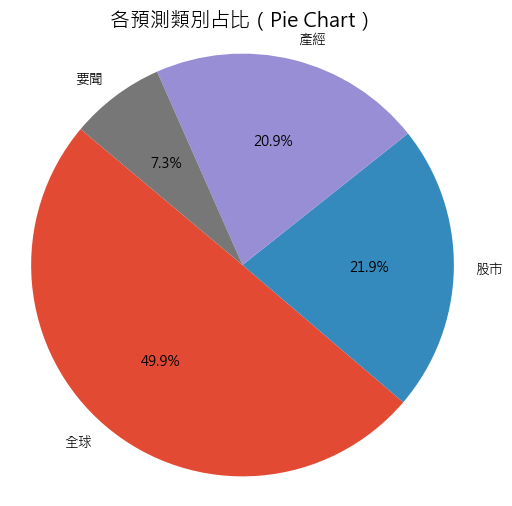

In [104]:
import matplotlib.pyplot as plt

# 統計各類別預測數量
pred_counts = pd.Series(y_pred).value_counts()

# 畫出餅圖
plt.figure(figsize=(6, 6))
plt.pie(pred_counts, labels=pred_counts.index, autopct='%1.1f%%', startangle=140)
plt.title("各預測類別占比（Pie Chart）")
plt.axis('equal')  # 讓餅圖圓形
plt.show()

全球的佔比最高，我們推論由於這段期間川普就任，容易與國際政治、政策、國際金融事件，模型將這類具「全球視野」或國際背景的文章，傾向分類為「全球」

In [101]:
ptt['pred'] = y_pred
ptt.loc[:,['words', 'artCatagory',"pred"]]

,words,artCatagory,pred
0,情報 倫斯基 一位 獨裁者 標題 倫斯基 一位 獨裁者 來源 最新 發文 網址 https ...,Stock,全球
1,新聞 五角大廈 預算 數據分析 Palantir 原文 標題 五角大廈 預算 數據分析 Pa...,Stock,全球
2,Re 情報 倫斯基 一位 獨裁者 奇怪 股版 越來越 股點 文章 乍看 還以 隔壁 對岸 柵...,Stock,全球
3,請益 這波 技術 保護 台積 電跌 下去 台積電 強制 美國 一座 米廠 投資 150 億美...,Stock,股市
4,新聞 台積 魏哲家 一把 鼻涕 一把 眼淚 美國 原文 標題 台積 魏哲家 一把 鼻涕 一把...,Stock,全球
...,...,...,...
698,新聞 川普要 中國 製造 船隻 徵收 天價 港口 費美 原文 標題 川普要 中國 製造 船隻...,Stock,全球
699,新聞 投資人 評估 經濟 現況 美債殖 利率 下跌 原文 標題 投資人 評估 經濟 現況 美...,Stock,股市
700,新聞 楊金龍 若漲 電價 CPI 修至 2.04% 央行 原文 標題 楊金龍 若漲 電價 C...,Stock,產經
701,新聞 總統 台積電 以外 產業 將東拓 原文 標題 出席 商會 年飯 總統 台積電 以外 產...,Stock,要聞


In [102]:
ptt.loc[ptt['pred'] == '全球', ['words', 'pred']].head(20)

,words,pred
0,情報 倫斯基 一位 獨裁者 標題 倫斯基 一位 獨裁者 來源 最新 發文 網址 https ...,全球
1,新聞 五角大廈 預算 數據分析 Palantir 原文 標題 五角大廈 預算 數據分析 Pa...,全球
2,Re 情報 倫斯基 一位 獨裁者 奇怪 股版 越來越 股點 文章 乍看 還以 隔壁 對岸 柵...,全球
4,新聞 台積 魏哲家 一把 鼻涕 一把 眼淚 美國 原文 標題 台積 魏哲家 一把 鼻涕 一把...,全球
5,Re 新聞 Trumpthreatens25% tariffsonforeign 忽略 選在...,全球
6,新聞 價值 美元 美國 晶片 大神 重話 原文 標題 價值 美元 美國 晶片 大神 重話 分...,全球
10,新聞 陸穩 外資 行動 方案 官員 投資 中國 未來 原文 標題 陸穩 外資 行動 方案 官...,全球
11,新聞 推行 促進 成長 議程 滯脹 推行 促進 成長 議程 滯脹 擔憂 困擾 美國市場 ht...,全球
12,新聞 中國 達成 貿易 協議 預期 中央社 https bit ly 41jnRk5 中國 ...,全球
13,新聞 關稅 政策 風險 瑞銀 金價 今年 30 關稅 政策 風險 瑞銀 金價 今年 3000...,全球


高頻詞包含：「關稅」「聯準會」「Fed」「美元」「美國」「制裁」「經濟」「中美貿易」「Palantir」等

這些詞彙高度與國際新聞、政治與經濟議題相關，尤其是「川普 + 關稅/政策」幾乎是全球新聞的標配。

文章雖來自股票版，但內容偏向「國際局勢影響台灣經濟」，因此分類器會認為它更貼近「全球」而非「股市」或「產經」。

In [103]:
pprint(ptt.loc[14, 'words'])

('新聞 關稅 政策 帶來 風險 考慮 暫停 QT 原文 標題 Fed 會議紀要 關稅 政策 帶來 風險 考慮 暫停 QT 原文 連結 https '
 'reurl cc XZnv2M 發布 時間 2025.02 20 06 57 記者 署名 工商時報 呂佳恩 原文 內容 國聯 準會 19 公布 前次 '
 '會議 會議紀要 與會 官員 一致 認為 進一步 降息 之前 看到 繼續 下降 尤其 考量 貿易 移民 政策 潛在 變化 影響 前景 存在 風險 考慮 '
 '美國聯邦 債務 上限 問題 官員 討論 放緩 暫停 量化 緊縮 QT 過程 美國聯邦 公開市場 委員會 FOMC 28 日至 29 召開 利率 決策 '
 '會議 會後 宣布 按兵 聯邦 基金 利率 維持 4.25 4.5 目標 區間 去年 啟動 降息 周期 以來 首次 行動 周三 公布 會議紀要 做出 暫停 '
 '降息 定時 與會 官員 針對 Donald Trump 新政府 帶來 影響 進行 討論 包括 加徵 關稅 減少 監管 稅收 動態 與會 官員 表示 目前 '
 '利率政策 當局 時間 評估 經濟 活動 勞動力 市場 變化 前景 經濟 接近 最大 就業 水準 官員 希望 進一步 調整 利率 之前 看到 下降 進展 '
 '官員 點出 財政政策 變化 導致 通膨率 維持 當局 目標 之上 潛在 貿易 移民 政策 變化 強勁 消費者 需求 感到 擔憂 多個 地區 商業 連絡 '
 '表示 企業 嘗試 潛在 關稅 導致 投入 成本 轉嫁給 消費者 針對 關稅 措施 頻頻 發出 關稅 威脅 聯準 主席 鮑爾 Jerome Powell '
 '會議 記者會 表示 目前 並不知道 關稅 移民 財政政策 監管 政策 發生 避免 對川普 關稅 政策 做出 評論 聯準 官員 陸續 表達 關稅 政策 '
 '擔憂 坦言 措施 影響 貨幣政策 一步 推遲 降息 會議紀要 出爐 素有 聯準 傳聲筒 之稱 華爾街日報 記者 蒂米 羅斯 Nick Timiraos '
 '撰文 本次 紀要 並未 傳遞 太多 利率 相關 消息 QT 討論 值得 關注 會議紀要 官員 會議 表示 現時 適合 考慮 暫停 放緩 QT 直至 聯邦 '
 '債務 上限 問題 得到 解決 為止 蒂米 羅斯 指出 債務 上限 相關 市場動態 導致

已其中一文章為例，內容聚焦於「Fed 貨幣政策」、「FOMC 利率會議」、「債務上限」、「川普評論」等全球經濟重大議題，導致分類器根據關鍵詞將其誤判為「全球」類別。

# 3. 主題模型（中文）

### 3.1 套件說明

In [106]:
import time 
from functools import reduce
from collections import Counter
from pprint import pprint

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import jieba
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from gensim.corpora import Dictionary
from gensim.models import LdaModel, CoherenceModel
from gensim.models.ldamulticore import LdaMulticore
from gensim.matutils import corpus2csc, corpus2dense, Sparse2Corpus

import pyLDAvis
import pyLDAvis.gensim_models

In [107]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [108]:
# 使圖中中文能正常顯示
# plt.rcParams['font.sans-serif'] = ['Arial Unicode Ms'] # MacOS
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']

# 使負號能夠顯示 
plt.rcParams['axes.unicode_minus'] = False

### 3.2 資料前處理

In [109]:
# 匯入資料
udn = pd.read_csv("raw_data/udn3.csv")
udn.head(3)

,system_id,artTitle,artDate,artCatagory,artUrl,artContent,artSecondCategory,dataSource,artSecondCatagory
0,1,美退將籲美台加強聯訓合作 發揮「2+2=5」戰力,2025-02-21 21:58:00,要聞,https://udn.com/news/story/10930/8563859,美國海軍退役少將蒙哥馬利今天表示，由於美台兩軍現在沒有充分的整合與協調，目前美台的聯合戰力有...,NaN,UDN,NaN
1,2,我國防預算目標達GDP3%以上 黃仁：台灣安全與外交政策方向錯誤,2025-02-22 18:51:00,要聞,https://udn.com/news/story/10930/8565217,賴清德總統日前舉行國安高層會議，會後表示將優先編列特別預算，讓國防預算達到GDP3%以上。國...,NaN,UDN,NaN
2,3,美軍少將參與漢光兵推？ 專家：有前例可平常心看待,2025-02-22 19:33:00,要聞,https://udn.com/news/story/10930/8565244,國防部長顧立雄視導漢光演習圖上兵推，卻被發現身旁座位出現美國印太司令部聯五少將的名牌。國防院...,NaN,UDN,NaN


In [110]:
# 移除網址格式
# 只留下中文字
udn["artContent"] = udn["artContent"].str.replace("(http|https)://.*", "", regex=True)
udn["artTitle"] = udn["artTitle"].str.replace("(http|https)://.*", "", regex=True)
udn["artContent"] = udn["artContent"].str.replace("[^\u4e00-\u9fa5]+", "", regex=True)
udn["artTitle"] = udn["artTitle"].str.replace("[^\u4e00-\u9fa5]+", "", regex=True)
udn['artDate'] = pd.to_datetime(udn['artDate'])
udn['content'] = udn['artContent']
udn["content"] = udn["content"].fillna("")  # 所有的空值都用空字串""來取代

# 文章內容、文章連結、看板、日期
udn = udn.loc[:,["content", "artUrl", "artCatagory", 'artDate']]  
udn.head(3)

,content,artUrl,artCatagory,artDate
0,美國海軍退役少將蒙哥馬利今天表示由於美台兩軍現在沒有充分的整合與協調目前美台的聯合戰力有如雙...,https://udn.com/news/story/10930/8563859,要聞,2025-02-21 21:58:00
1,賴清德總統日前舉行國安高層會議會後表示將優先編列特別預算讓國防預算達到以上國民黨立委黃仁今天...,https://udn.com/news/story/10930/8565217,要聞,2025-02-22 18:51:00
2,國防部長顧立雄視導漢光演習圖上兵推卻被發現身旁座位出現美國印太司令部聯五少將的名牌國防院戰略...,https://udn.com/news/story/10930/8565244,要聞,2025-02-22 19:33:00


In [111]:
# 設定繁體中文詞庫
jieba.set_dictionary("./dict/dict.txt.big")

# 新增 stopwords
with open("./dict/stop_words.txt", encoding="utf-8") as f:
    stopWords = [line.strip() for line in f.readlines()]

# 設定斷詞 function
def getToken(row):
    seg_list = jieba.cut(row, cut_all=False)
    seg_list = [
        w for w in seg_list if w not in stopWords and len(w) > 1
    ]  # 篩選掉停用字與字元數大於 1 的詞彙
    return seg_list

udn["words"] = udn["content"].apply(getToken)
udn.head()

Building prefix dict from d:\113-2 SMA\讀書會\report2\dict\dict.txt.big ...
2025-04-20 22:40:14,379 : DEBUG : Building prefix dict from d:\113-2 SMA\讀書會\report2\dict\dict.txt.big ...
Loading model from cache C:\Users\HM-B01\AppData\Local\Temp\jieba.uc38b0eb146461e7dac235730a431b7c0.cache
2025-04-20 22:40:14,383 : DEBUG : Loading model from cache C:\Users\HM-B01\AppData\Local\Temp\jieba.uc38b0eb146461e7dac235730a431b7c0.cache
Loading model cost 0.920 seconds.
2025-04-20 22:40:15,303 : DEBUG : Loading model cost 0.920 seconds.
Prefix dict has been built successfully.
2025-04-20 22:40:15,304 : DEBUG : Prefix dict has been built successfully.


,content,artUrl,artCatagory,artDate,words
0,美國海軍退役少將蒙哥馬利今天表示由於美台兩軍現在沒有充分的整合與協調目前美台的聯合戰力有如雙...,https://udn.com/news/story/10930/8563859,要聞,2025-02-21 21:58:00,"[美國, 海軍, 退役, 少將, 蒙哥馬利, 今天, 表示, 美台, 現在, 整合, 協調,..."
1,賴清德總統日前舉行國安高層會議會後表示將優先編列特別預算讓國防預算達到以上國民黨立委黃仁今天...,https://udn.com/news/story/10930/8565217,要聞,2025-02-22 18:51:00,"[賴清德, 總統, 日前, 舉行, 國安, 高層, 會議, 會後, 表示, 優先, 編列, ..."
2,國防部長顧立雄視導漢光演習圖上兵推卻被發現身旁座位出現美國印太司令部聯五少將的名牌國防院戰略...,https://udn.com/news/story/10930/8565244,要聞,2025-02-22 19:33:00,"[國防部長, 顧立, 雄視, 漢光, 演習, 圖上, 推卻, 發現, 身旁, 座位, 出現,..."
3,路透社報導美國總統川普政府釋出先前凍結的億美元外交援助包括用於台灣計畫的億美元學者分析川普政...,https://udn.com/news/story/10930/8565329,要聞,2025-02-22 21:05:00,"[路透社, 報導, 美國, 總統, 川普, 政府, 釋出, 先前, 凍結, 億美元, 外交,..."
4,兩名美國學者今天發表專文建議美國總統川普將對台灣的軍事援助與台灣的國防支出及改革掛鉤讓台灣建...,https://udn.com/news/story/10930/8571966,要聞,2025-02-26 09:02:00,"[兩名, 美國, 學者, 今天, 發表, 專文, 建議, 美國, 總統, 川普將, 台灣, ..."


### 3.3 LDA 主題模型
#### 3.3.1 正式處理新聞

In [112]:
# 將斷詞後的 doc['words'] 轉換成 list
docs = udn['words'].to_list()
docs[0]

['美國',
 '海軍',
 '退役',
 '少將',
 '蒙哥馬利',
 '今天',
 '表示',
 '美台',
 '現在',
 '整合',
 '協調',
 '目前',
 '美台',
 '聯合',
 '戰力',
 '有如',
 '雙方',
 '陸海空軍',
 '共同',
 '訓練',
 '必要性',
 '年內',
 '好好',
 '執行',
 '將能',
 '發揮',
 '戰力',
 '現在',
 '落實',
 '周刊',
 '今天下午',
 '在政',
 '大公',
 '中心',
 '舉行',
 '沸騰',
 '護城河',
 '新書',
 '發表',
 '座談會',
 '作者',
 '美國',
 '白宮',
 '國家',
 '安全',
 '顧問',
 '博明',
 '共同',
 '作者',
 '美國',
 '海軍',
 '退役',
 '少將',
 '蒙哥馬利',
 '出席',
 '座談',
 '台灣',
 '阻絕',
 '中國',
 '優勢',
 '博明',
 '指出',
 '台灣',
 '優勢',
 '台灣',
 '海峽',
 '將台灣',
 '中國',
 '大陸',
 '隔開',
 '台灣',
 '海峽',
 '雙面',
 '台灣',
 '戰時',
 '面臨',
 '補給',
 '困難',
 '台灣',
 '平時',
 '儲備',
 '對稱',
 '作戰',
 '資源',
 '包含',
 '戰車',
 '飛彈',
 '水雷',
 '無人機',
 '確保',
 '台灣',
 '戰事',
 '中能',
 '保持',
 '戰略地位',
 '博明',
 '表示',
 '總統',
 '賴清德',
 '日前',
 '宣示',
 '透過',
 '特別',
 '預算',
 '方式',
 '國防',
 '預算',
 '提升',
 '支持',
 '做法',
 '決策',
 '這是給',
 '支持',
 '台灣',
 '美方',
 '友人',
 '中國',
 '領導人',
 '習近平',
 '明確',
 '信號',
 '針對',
 '台海',
 '局勢',
 '蒙哥馬利',
 '指出',
 '每年',
 '參與',
 '到次',
 '好消息',
 '絕大多數',
 '時刻',
 '好人',
 '會贏',
 '壞消息',
 '是從',
 '發現',
 '區域',
 '國家',
 '

In [113]:
# 建立並過濾詞彙表（dictionary），只保留特定條件的詞彙
dictionary = Dictionary(docs)

# no_below=5，出現在少於 5 篇文章中的詞會被移除
# no_above=0.99，出現在超過 99% 文件中的詞會被移除
dictionary.filter_extremes(no_below=5, no_above=0.99)
print(dictionary)

2025-04-20 22:40:59,953 : INFO : adding document #0 to Dictionary<0 unique tokens: []>
2025-04-20 22:41:00,955 : INFO : built Dictionary<67127 unique tokens: ['中國', '中國軍力', '中心', '中能', '今天']...> from 5829 documents (total 1488752 corpus positions)
2025-04-20 22:41:00,956 : INFO : Dictionary lifecycle event {'msg': "built Dictionary<67127 unique tokens: ['中國', '中國軍力', '中心', '中能', '今天']...> from 5829 documents (total 1488752 corpus positions)", 'datetime': '2025-04-20T22:41:00.956663', 'gensim': '4.3.3', 'python': '3.11.0 | packaged by Anaconda, Inc. | (main, Mar  1 2023, 18:18:21) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.26100-SP0', 'event': 'created'}
2025-04-20 22:41:01,001 : INFO : discarding 49964 tokens: [('中國軍力', 3), ('到次', 2), ('博明', 2), ('在政', 1), ('大公', 2), ('好人', 4), ('快且', 4), ('會贏', 4), ('水雷', 4), ('沸騰', 2)]...
2025-04-20 22:41:01,002 : INFO : keeping 17163 tokens which were in no less than 5 and no more than 5770 (=99.0%) documents
2025-04-20 22:41:01,027 

Dictionary<17163 unique tokens: ['中國', '中心', '中能', '今天', '今天下午']...>


In [114]:
# 看詞彙跟 ID 的對應
for idx, (k, v) in enumerate(dictionary.token2id.items()):
    print(f"{k}: {v}")
    if idx > 10:
        break

中國: 0
中心: 1
中能: 2
今天: 3
今天下午: 4
以色列: 5
任期: 6
任職: 7
作戰: 8
作者: 9
保持: 10
信心: 11


將斷詞結果建構語料庫(corpus)之後，利用語料庫把每篇文章數字化。<br>
每個詞彙都被賦予一個 ID 及頻率(word_id，word_frequency)。<br>

舉例來說：<br>
第一篇文章數字化結果為：corpus[600]:[(2, 2), (6, 1), (20, 2), .... ]，element 為文章中每個詞彙的 id 和頻率。<br>
代表：'世界'出現 2 次、'之戰'出現一次...以此類推

In [115]:
# 第 600 篇文章
pprint(" ".join(udn['words'].iloc[600]))

('華盛頓 時報 報導 美國 總統 川普 副手 范斯 日前 烏克蘭 總統 白宮 陷入 激烈 口角 雙方 未能 簽署 礦產 協議 不歡而散 川普 國安 顧問 '
 '沃茲 受訪 稱澤 倫斯基 搞砸 前女友 翻舊帳 美烏 會談 當時 范斯 提到 戰爭 外交 方式 結束 倫斯基 回問 哪門子 外交 范斯接 提高 嗓門 '
 '雙方 陷入 爭執 隨後 礦產 協議 不了了之 沃茲 國務卿 魯比 交代 請澤 倫斯基 離開 白宮 沃茲 接受 保守派 媒體 布萊 巴特 廣播 電台 訪問 '
 '描述 倫斯基 搞砸 倫斯基 顯然 專注 事實 查核 糾正 每個 細微 差異 沃茲 這就 前女友 年前 帳不放 努力 推進 兩人 關係 報導 指出 部分 '
 '共和黨人 一致 認為澤 倫斯基 白宮 表現 尊重 並對川普 作法 表示 稱讚 沃茲 表達 相同 看法 宣稱 魯比 歐為 簽訂 礦產 協議 付出 很大 '
 '心力 就連 長期 支持 倫斯基 南卡 參議員 葛理漢 表示 這次 白熱化 美烏 會談 烏克蘭 應該 進行 政權 更迭 對此 沃茲 並未 表態 質疑 '
 '倫斯基 是否 帶領 烏克蘭 進入 下一階段 恢復 穩定 引爆 川普 倫斯基 大吵 還原 史無前例 現場 川普澤 倫斯基 談崩 歐洲 事先 設局 官員 '
 '震驚 早要 他別 上當 徹底改變 參議員 辭職 倫斯基 回應 烏克蘭 頓失 山川 白宮 大吵 無人機 轟炸 哈爾科夫 醫院 緩和 倫斯基 下逐客令 會後 '
 '挖苦 四喊 感謝 川普澤 倫斯基 白宮 舌戰 烏駐 大使 表情 動作 心聲 回不去')


In [116]:
# 第 600 篇文章的前十個詞彙的語料庫 ID 和頻率
dictionary.doc2bow(udn['words'].iloc[600])[:10]

[(51, 3),
 (67, 1),
 (70, 1),
 (75, 1),
 (76, 1),
 (89, 4),
 (90, 1),
 (98, 5),
 (105, 2),
 (107, 1)]

In [117]:
# 將 docs 轉換成 BOW 形式（Bag-of-words 作為文章的特徵表示）
# 把每篇文件的 token list 轉換成一組 (token_id, count) 的 list 
corpus = [dictionary.doc2bow(doc) for doc in docs]

#### 3.3.2 開始訓練 LDA topic model

+ 參數說明：
    + corpus = 文檔語料庫
    + id2word = 詞彙字典
    + num_topics = 生成幾個主題數
    + random_state = 固定亂數值，每次的模型結果會一樣
    + iteration = 每個文章訓練的次數，可以設定高一點讓模型收斂
    + passes(epoch) = 整個 corpus 訓練模型的次數
    + alpha = 文章主題分佈
    + eta = 主題字分佈

模型參數沒有一個絕對的答案，同學們應該**使用相同的資料**，嘗試做參數上的調整，進而比較出較佳的模型結果。

In [118]:
ldamodel = LdaModel(
    corpus=corpus, 
    id2word=dictionary, # 字典
    num_topics=10, # 生成幾個主題數
    random_state=2024, # 亂數
    iterations=100,
    passes = 7
)

2025-04-20 22:41:01,689 : INFO : using symmetric alpha at 0.1
2025-04-20 22:41:01,690 : INFO : using symmetric eta at 0.1
2025-04-20 22:41:01,693 : INFO : using serial LDA version on this node
2025-04-20 22:41:01,706 : INFO : running online (multi-pass) LDA training, 10 topics, 7 passes over the supplied corpus of 5829 documents, updating model once every 2000 documents, evaluating perplexity every 5829 documents, iterating 100x with a convergence threshold of 0.001000
2025-04-20 22:41:01,707 : INFO : PROGRESS: pass 0, at document #2000/5829
2025-04-20 22:41:03,280 : INFO : merging changes from 2000 documents into a model of 5829 documents
2025-04-20 22:41:03,293 : INFO : topic #0 (0.100): 0.014*"美國" + 0.013*"中國" + 0.011*"川普" + 0.009*"台灣" + 0.007*"表示" + 0.006*"總統" + 0.006*"國家" + 0.006*"歐洲" + 0.005*"德國" + 0.005*"烏克蘭"
2025-04-20 22:41:03,294 : INFO : topic #8 (0.100): 0.019*"美國" + 0.013*"烏克蘭" + 0.013*"川普" + 0.009*"倫斯基" + 0.007*"中國" + 0.007*"總統" + 0.006*"歐洲" + 0.006*"表示" + 0.006*"俄羅斯" + 0

#### 3.3.3 查看 LDA 主題代表字

當 LDA 模型訓練好之後，我們可以查看每個主題的單詞分佈。<br>
num_words = 選擇要查看每個主題前幾個字。<br>

In [119]:
ldamodel.print_topics()

2025-04-20 22:41:29,659 : INFO : topic #0 (0.100): 0.016*"中國" + 0.015*"台灣" + 0.011*"美國" + 0.007*"國家" + 0.006*"德國" + 0.006*"政府" + 0.006*"政策" + 0.005*"川普" + 0.005*"經濟" + 0.005*"表示"
2025-04-20 22:41:29,661 : INFO : topic #1 (0.100): 0.009*"川普" + 0.007*"加拿大" + 0.007*"表示" + 0.007*"關稅" + 0.006*"倫斯基" + 0.006*"日本" + 0.005*"發生" + 0.005*"報導" + 0.004*"教宗" + 0.004*"調查"
2025-04-20 22:41:29,663 : INFO : topic #2 (0.100): 0.012*"專家" + 0.010*"川普" + 0.009*"美國" + 0.007*"好處" + 0.006*"表示" + 0.005*"報導" + 0.005*"母親" + 0.005*"稀土" + 0.005*"主席" + 0.005*"協議"
2025-04-20 22:41:29,666 : INFO : topic #3 (0.100): 0.029*"關稅" + 0.029*"美國" + 0.011*"中國" + 0.011*"川普" + 0.008*"公司" + 0.008*"晶片" + 0.008*"大陸" + 0.007*"表示" + 0.007*"生產" + 0.006*"台灣"
2025-04-20 22:41:29,667 : INFO : topic #4 (0.100): 0.033*"美國" + 0.028*"台灣" + 0.020*"投資" + 0.019*"台積電" + 0.016*"台股" + 0.012*"總統" + 0.011*"川普" + 0.011*"台積" + 0.010*"表示" + 0.009*"積電"
2025-04-20 22:41:29,669 : INFO : topic #5 (0.100): 0.028*"美國" + 0.026*"烏克蘭" + 0.021*"川普" + 0.011*"總統" 

[(0,
  '0.016*"中國" + 0.015*"台灣" + 0.011*"美國" + 0.007*"國家" + 0.006*"德國" + 0.006*"政府" + 0.006*"政策" + 0.005*"川普" + 0.005*"經濟" + 0.005*"表示"'),
 (1,
  '0.009*"川普" + 0.007*"加拿大" + 0.007*"表示" + 0.007*"關稅" + 0.006*"倫斯基" + 0.006*"日本" + 0.005*"發生" + 0.005*"報導" + 0.004*"教宗" + 0.004*"調查"'),
 (2,
  '0.012*"專家" + 0.010*"川普" + 0.009*"美國" + 0.007*"好處" + 0.006*"表示" + 0.005*"報導" + 0.005*"母親" + 0.005*"稀土" + 0.005*"主席" + 0.005*"協議"'),
 (3,
  '0.029*"關稅" + 0.029*"美國" + 0.011*"中國" + 0.011*"川普" + 0.008*"公司" + 0.008*"晶片" + 0.008*"大陸" + 0.007*"表示" + 0.007*"生產" + 0.006*"台灣"'),
 (4,
  '0.033*"美國" + 0.028*"台灣" + 0.020*"投資" + 0.019*"台積電" + 0.016*"台股" + 0.012*"總統" + 0.011*"川普" + 0.011*"台積" + 0.010*"表示" + 0.009*"積電"'),
 (5,
  '0.028*"美國" + 0.026*"烏克蘭" + 0.021*"川普" + 0.011*"總統" + 0.011*"倫斯基" + 0.011*"歐洲" + 0.010*"俄羅斯" + 0.009*"表示" + 0.008*"國家" + 0.008*"協議"'),
 (6,
  '0.014*"市場" + 0.012*"美國" + 0.009*"關稅" + 0.008*"經濟" + 0.008*"投資" + 0.007*"指數" + 0.007*"成長" + 0.006*"今年" + 0.006*"川普" + 0.006*"政策"'),
 (7,
  '0.019*"川普" + 

根據每個主題的詞彙分佈來猜測，該主題可能是有關什麼樣的議題：
+ 主題一：中美台關係與政策
+ 主題二：國際政治事件
+ 主題三：專家評論與川普政策影響
+ 主題四：關稅貿易相關
+ 主題五：科技產業相關
+ 主題六：俄烏戰爭情勢
+ 主題七：經濟趨勢
+ 主題八：川普相關爭議事件
+ 主題九：白宮外交發言
+ 主題十：俄烏戰爭談判

In [120]:
# 也可以使用 get_document_topics() 回去看每篇文章的主題分佈 (`theta`)
ldamodel.get_document_topics(corpus[0])

[(0, 0.6376317),
 (3, 0.050079554),
 (4, 0.2405255),
 (7, 0.048077103),
 (8, 0.021425037)]

這邊可以看到 corpus[0] 這篇文章是由多個主題混合組成，每個主題都有其機率（權重）
其中主題 0 的佔比最高 0.64

#### 3.3.4 查看 LDA 模型指標
+ **Pointwise Mutual Information (PMI)** : <br>
自然語言處理中，想要探討兩個字之間是否存在某種關係。<br>
例如：某些字會一起出現，可能帶有某些訊息，因此這個可以用 PMI 來計算，數字越大越好。
+ **perplexity** :<br>
perplexity 也是評估的指標之一，廣泛用於語言模型的評估，意思為複雜度，因此數字要越小越好。

In [121]:
# perplexity
perplexity = ldamodel.log_perplexity(corpus)
perplexity

2025-04-20 22:41:33,337 : INFO : -7.987 per-word bound, 253.8 perplexity estimate based on a held-out corpus of 5829 documents with 1393042 words


-7.987305787808446

In [122]:
# 將對數 perplexity 值轉回原始的 perplexity 值
np.exp2(-perplexity)

253.75734787752563

In [123]:
# npmi
NPMI_model_lda = CoherenceModel(model=ldamodel, texts=docs, coherence='c_npmi')
NPMI_lda = NPMI_model_lda.get_coherence()
print('這個主題模型的 PMI score: ', NPMI_lda)

2025-04-20 22:41:33,372 : INFO : using ParallelWordOccurrenceAccumulator<processes=11, batch_size=64> to estimate probabilities from sliding windows
2025-04-20 22:41:46,196 : INFO : 1 batches submitted to accumulate stats from 64 documents (14026 virtual)
2025-04-20 22:41:46,200 : INFO : 2 batches submitted to accumulate stats from 128 documents (30824 virtual)
2025-04-20 22:41:46,205 : INFO : 3 batches submitted to accumulate stats from 192 documents (46218 virtual)
2025-04-20 22:41:46,208 : INFO : 4 batches submitted to accumulate stats from 256 documents (61505 virtual)
2025-04-20 22:41:46,212 : INFO : 5 batches submitted to accumulate stats from 320 documents (77334 virtual)
2025-04-20 22:41:46,217 : INFO : 6 batches submitted to accumulate stats from 384 documents (94800 virtual)
2025-04-20 22:41:46,221 : INFO : 7 batches submitted to accumulate stats from 448 documents (112072 virtual)
2025-04-20 22:41:46,226 : INFO : 8 batches submitted to accumulate stats from 512 documents (12

這個主題模型的 PMI score:  -0.02114221187002808


In [124]:
# 列出主題模型中，每個主題詞語之間的 PMI score
NPMI_model_lda.get_coherence_per_topic()

[0.023330737995494365,
 -0.029343550024358296,
 -0.18620900160136183,
 0.04623159522756409,
 0.0444796889346524,
 0.020199927358466454,
 0.036084727718766516,
 -0.07852144760709076,
 -0.11115849073638134,
 0.023483694033967654]

`NPMI` 的值域是[-1,1]，-1 代表兩個字沒一起出現過，0 代表兩個字之間獨立，1 代表兩個字完全相關

#### 3.3.5 透過指標找出最佳主題數

透過建立不同主題數的模型，並以上述所說的**判斷指標**來找出最佳的主題數。<br>
這裡我們選擇主題數 2~10 來做分析。

**再次強調**：主題數及參數沒有一個絕對正確的答案，同學們應該**使用相同的資料**，嘗試做參數上的調整、主題數的調整，進而比較出較佳的模型結果。

In [125]:
t0 = time.time()

topic_num_list = np.arange(2, 10)
result = {"topic_num":[], "perplexity":[], "pmi":[]}
model_set = dict()


for topic_num in topic_num_list:
    # perplexity
    model = LdaModel(
        corpus = corpus,
        num_topics = topic_num ,
        id2word=dictionary,
        random_state = 1500,
        passes=5 # 訓練次數
        )
    
    loss = model.log_perplexity(corpus)
    pmi = CoherenceModel(model=model, texts=docs, coherence='c_npmi').get_coherence()
    perplexity = np.exp(-1. * loss)
    
    # model_set[f'k_{topic_num}'] = model
    
    result['topic_num'].append(topic_num)
    result['perplexity'].append(perplexity)
    result['pmi'].append(pmi)
    
print(f"花費時間: {time.time() - t0} sec")


2025-04-20 22:41:49,346 : INFO : using symmetric alpha at 0.5
2025-04-20 22:41:49,348 : INFO : using symmetric eta at 0.5
2025-04-20 22:41:49,351 : INFO : using serial LDA version on this node
2025-04-20 22:41:49,356 : INFO : running online (multi-pass) LDA training, 2 topics, 5 passes over the supplied corpus of 5829 documents, updating model once every 2000 documents, evaluating perplexity every 5829 documents, iterating 50x with a convergence threshold of 0.001000
2025-04-20 22:41:49,358 : INFO : PROGRESS: pass 0, at document #2000/5829
2025-04-20 22:41:50,239 : INFO : merging changes from 2000 documents into a model of 5829 documents
2025-04-20 22:41:50,241 : INFO : topic #0 (0.500): 0.023*"美國" + 0.015*"川普" + 0.011*"關稅" + 0.011*"烏克蘭" + 0.010*"總統" + 0.009*"表示" + 0.006*"台灣" + 0.006*"俄羅斯" + 0.006*"中國" + 0.005*"倫斯基"
2025-04-20 22:41:50,242 : INFO : topic #1 (0.500): 0.015*"烏克蘭" + 0.015*"美國" + 0.012*"川普" + 0.011*"倫斯基" + 0.007*"表示" + 0.006*"中國" + 0.006*"總統" + 0.005*"關稅" + 0.005*"協議" + 0.

花費時間: 247.8681046962738 sec


In [126]:
result = pd.DataFrame(result)
result

,topic_num,perplexity,pmi
0,2,3403.008650,0.023991
1,3,3205.125452,0.017060
2,4,3024.316954,0.024947
3,5,2898.228585,0.033145
4,6,2846.264672,0.019607
5,7,2802.702322,0.002038
6,8,2768.923903,0.000628
7,9,2779.468277,0.001152


<Axes: xlabel='topic_num'>

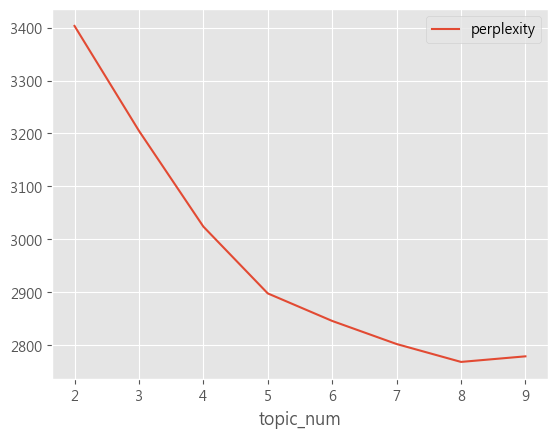

In [127]:
result.plot.line(x='topic_num', y='perplexity')

<Axes: xlabel='topic_num'>

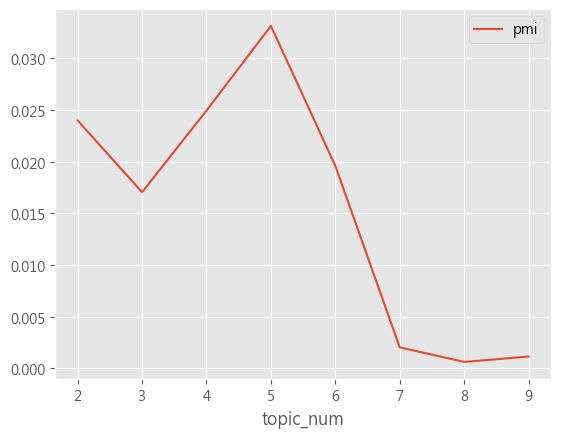

In [128]:
result.plot.line(x='topic_num', y='pmi')

就訓練結果來看，perplexity 最佳在 8，coherence 最高則是 5

### 3.4 視覺化呈現

LDAvis 是我們經常會使用的視覺化工具，目的為幫助我們解釋主題模型中，在我們建構好主題模型得到 θ(文件的主題分佈) 跟 φ(主題的字分佈)，透過 pyLDAvis 將主題降維成二維，以網頁的形式供我們查看。

+ 圓圈數量代表主題數量，有幾個主題就會有幾個圓圈
+ 圓越大代表 document 越大
+ 右邊可以看到主題的字分佈
+ 右上幫有一個 bar 調整 lambda：當 lambda=1 也就是代表本來的字分佈 φ，將 lambda 縮越小可以看到越唯一的字，好的分佈是 φ 高且唯一，因此我們要在這兩者間取平衡
+ 圓心越相近，代表主題會越相似；反之，圓心分越開代表主題有唯一性<br>
  --> 假設詞彙本來有 100 字，維度應該是 100，假如本來維度接近(相近)的話，降維後也會接近(相近)

以下用主題數 8 來做 LDAvis 的結果範例

In [129]:
best_model = LdaModel(
    corpus = corpus,
    num_topics = 8,
    id2word=dictionary,
    random_state = 1500,
    iterations=60,
    passes = 8 # 訓練次數
    )

2025-04-20 22:45:57,517 : INFO : using symmetric alpha at 0.125
2025-04-20 22:45:57,519 : INFO : using symmetric eta at 0.125
2025-04-20 22:45:57,522 : INFO : using serial LDA version on this node
2025-04-20 22:45:57,534 : INFO : running online (multi-pass) LDA training, 8 topics, 8 passes over the supplied corpus of 5829 documents, updating model once every 2000 documents, evaluating perplexity every 5829 documents, iterating 60x with a convergence threshold of 0.001000
2025-04-20 22:45:57,535 : INFO : PROGRESS: pass 0, at document #2000/5829
2025-04-20 22:45:58,484 : INFO : merging changes from 2000 documents into a model of 5829 documents
2025-04-20 22:45:58,490 : INFO : topic #4 (0.125): 0.022*"美國" + 0.015*"關稅" + 0.014*"川普" + 0.009*"中國" + 0.008*"表示" + 0.007*"歐洲" + 0.007*"台灣" + 0.007*"倫斯基" + 0.006*"總統" + 0.005*"烏克蘭"
2025-04-20 22:45:58,491 : INFO : topic #2 (0.125): 0.019*"美國" + 0.011*"中國" + 0.008*"台灣" + 0.008*"川普" + 0.007*"表示" + 0.007*"關稅" + 0.006*"烏克蘭" + 0.006*"總統" + 0.005*"國家" + 

In [130]:
pyLDAvis.enable_notebook()
p = pyLDAvis.gensim_models.prepare(best_model, corpus, dictionary)
p

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.277874  0.019220       1        1  24.390438
3      0.114812 -0.106658       2        1  14.786492
2     -0.088747 -0.063207       3        1  13.595889
1      0.083687  0.190503       4        1  11.594672
4     -0.132750  0.024683       5        1  11.202484
6      0.107755  0.012150       6        1   8.998962
5      0.074497 -0.160888       7        1   8.601502
7      0.118622  0.084196       8        1   6.829561, topic_info=     Term         Freq        Total Category  logprob  loglift
27     台灣  6619.000000  6619.000000  Default  30.0000  30.0000
89    烏克蘭  7204.000000  7204.000000  Default  29.0000  29.0000
161   倫斯基  5332.000000  5332.000000  Default  28.0000  28.0000
1769   關稅  9999.000000  9999.000000  Default  27.0000  27.0000
1840   市場  4583.000000  4583.000000  Default  26.0000  26.0000
...   ...          ...          ...      ...      ...      ...
105    總統   550.302400  7071.261454   Topic8  -5.1526   0.1306
327    報導   435.207149  3840.593910   Topic8  -5.3873   0.5063
221    政府   414.759338  4970.201529   Topic8  -5.4354   0.2004
8921  巴菲特   320.145700   697.421808   Topic8  -5.6943   1.9053
1258   宣布   325.039297  2624.994796   Topic8  -5.6791   0.5950

[650 rows x 6 columns], token_table=       Topic      Freq Term
term                       
2409       1  0.001565   一名
2409       2  0.173720   一名
2409       3  0.004695   一名
2409       4  0.530549   一名
2409       5  0.004695   一名
...      ...       ...  ...
2615       6  0.007647   點出
2615       7  0.002549   點出
2615       8  0.010195   點出
11008      2  0.994289   點餐
7891       2  0.990786   齊爆

[1878 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 4, 3, 2, 5, 7, 6, 8])

可以看到 (2,7)、(6,8)、(3,5) 很相近，試試看跑 5 個主題

In [131]:
model_5 = LdaModel(
    corpus = corpus,
    num_topics = 5,
    id2word=dictionary,
    random_state = 1500,
    passes = 5 # 訓練次數
    )
pyLDAvis.enable_notebook()
p = pyLDAvis.gensim_models.prepare(model_5, corpus, dictionary)
p

2025-04-20 22:46:26,101 : INFO : using symmetric alpha at 0.2
2025-04-20 22:46:26,102 : INFO : using symmetric eta at 0.2
2025-04-20 22:46:26,108 : INFO : using serial LDA version on this node
2025-04-20 22:46:26,119 : INFO : running online (multi-pass) LDA training, 5 topics, 5 passes over the supplied corpus of 5829 documents, updating model once every 2000 documents, evaluating perplexity every 5829 documents, iterating 50x with a convergence threshold of 0.001000
2025-04-20 22:46:26,121 : INFO : PROGRESS: pass 0, at document #2000/5829
2025-04-20 22:46:26,944 : INFO : merging changes from 2000 documents into a model of 5829 documents
2025-04-20 22:46:26,948 : INFO : topic #0 (0.200): 0.021*"美國" + 0.016*"川普" + 0.013*"關稅" + 0.010*"表示" + 0.009*"總統" + 0.008*"烏克蘭" + 0.008*"台灣" + 0.005*"俄羅斯" + 0.005*"中國" + 0.005*"政府"
2025-04-20 22:46:26,950 : INFO : topic #1 (0.200): 0.012*"美國" + 0.012*"烏克蘭" + 0.012*"川普" + 0.008*"表示" + 0.007*"倫斯基" + 0.006*"關稅" + 0.006*"中國" + 0.005*"協議" + 0.005*"台灣" + 0.0

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.239803  0.021604       1        1  27.114493
3      0.151334 -0.082454       2        1  21.642895
1      0.130583  0.129743       3        1  18.735747
2     -0.016879 -0.122306       4        1  17.167140
4     -0.025235  0.053413       5        1  15.339725, topic_info=     Term         Freq        Total Category  logprob  loglift
89    烏克蘭  6911.000000  6911.000000  Default  30.0000  30.0000
27     台灣  6852.000000  6852.000000  Default  29.0000  29.0000
161   倫斯基  5321.000000  5321.000000  Default  28.0000  28.0000
1840   市場  4505.000000  4505.000000  Default  27.0000  27.0000
1769   關稅  9704.000000  9704.000000  Default  26.0000  26.0000
...   ...          ...          ...      ...      ...      ...
511    研究   530.974238  1619.294007   Topic5  -5.9976   0.7597
228    時間   502.656697  1527.111382   Topic5  -6.0524   0.7635
105    總統   636.333131  7152.451359   Topic5  -5.8166  -0.5448
67     指出   560.423269  4065.298869   Topic5  -5.9436  -0.1068
2198   協議   518.975880  2982.151839   Topic5  -6.0204   0.1262

[476 rows x 6 columns], token_table=      Topic      Freq Term
term                      
8913      2  0.024386   一生
8913      3  0.013935   一生
8913      4  0.958041   一生
6430      1  0.937556   上漲
6430      2  0.001039   上漲
...     ...       ...  ...
2615      4  0.014626   點出
2615      5  0.940941   點出
2153      4  0.980007   黨團
7891      1  0.006807   齊爆
7891      2  0.987051   齊爆

[1319 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 4, 2, 3, 5])

替換成 5 個主題數後，可以發現文章有更明顯的分群，可以更好的觀察文本中的資訊！<br>
透過人工判定，查看不同主題裡面詞彙代表的主題類別！

* 主題1：主要與產經相關的主題，像是股市投資、財經分析和金融交易
* 主題2：主要與俄烏戰爭、國際相關
* 主題3：主要與社會事件、公共安全相關
* 主題4：主要與科技產業、晶片議題相關
* 主題5：主要與貿易政策、關稅衝突與中美經濟摩擦相關

我們可以透過兩個指標去做為選擇主題數的參考，但不一定是最佳解，還是可以透過人工去判斷

### 3.5 GuidedLDA

- 原始套件: <https://github.com/vi3k6i5/GuidedLDA>  
- 31lab 家銘修改版本: <https://github.com/Text-Analytics-and-Retrieval/GuidedLDA>

安裝方式:  
`pip install git+https://github.com/Text-Analytics-and-Retrieval/GuidedLDA.git#egg=GuidedLDA`  
經測試，在 `python3.7~3.11.0` 可正常執行

In [132]:
import guidedlda

In [133]:
word2id = dictionary.token2id

定義了以下 4 個主題的種子字，藉由給定每個主題一些關鍵字，去影響主題模型生成的結果！

In [134]:
seed_topic_list = [
    ["台積電", "晶片", "合作", "製成", "半導體", "供應鏈", "政策"],                     
    ["市場", "投資", "經濟", "指數", "台股", "股價"],                                 
    ["俄羅斯", "倫斯基", "協議", "停火", "烏克蘭", "戰爭", "衝突"],                     
    ["關稅", "進口", "徵收", "施壓", "貿易", "鋼鋁", "能源", "經濟部"],                                   
]

In [135]:
seed_topics = {}
for t_id, st in enumerate(seed_topic_list):
    for word in st:
        seed_topics[word2id[word]] = t_id

In [136]:
# guidedlda 需要 DTM 格式作為 input，因此這邊利用 corpus2dense() 方法進行轉換
X = corpus2dense(corpus, len(dictionary), len(corpus)).T.astype(np.int64)

In [137]:
model = guidedlda.GuidedLDA(n_topics=5, n_iter=100, random_state=7, refresh=20)
model.fit(X, seed_topics=seed_topics, seed_confidence=1)

2025-04-20 22:46:44,901 : INFO : n_documents: 5829
2025-04-20 22:46:44,902 : INFO : vocab_size: 17163
2025-04-20 22:46:44,902 : INFO : n_words: 1393042
2025-04-20 22:46:44,903 : INFO : n_topics: 5
2025-04-20 22:46:44,903 : INFO : n_iter: 100
2025-04-20 22:46:48,873 : INFO : <0> log likelihood: -14110183
2025-04-20 22:46:49,818 : INFO : <20> log likelihood: -11667080
2025-04-20 22:46:50,718 : INFO : <40> log likelihood: -11612651
2025-04-20 22:46:51,630 : INFO : <60> log likelihood: -11593794
2025-04-20 22:46:52,519 : INFO : <80> log likelihood: -11584978
2025-04-20 22:46:53,426 : INFO : <99> log likelihood: -11579037


In [138]:
vocab = tuple(dictionary.token2id.keys())

In [139]:
# 整理／顯示主題模型結果
n_top_words = 10
topic_word = model.topic_word_

for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][: -(n_top_words + 1) : -1]
    print("Topic {}: {}".format(i, " ".join(topic_words)))
    

doc_topic = model.doc_topic_ # 文件-主題 分佈
term_freq = tuple(dictionary.cfs.values()) # 每個詞在整個語料中出現的總次數
doc_len = [sum(v for k, v in doc) for doc in corpus] # 每篇文章的長度

## LDAvis
pyLDAvis.enable_notebook()
p = pyLDAvis.prepare(topic_word, doc_topic, doc_len, vocab = vocab, term_frequency = term_freq)
p

Topic 0: 美國 台灣 投資 中國 晶片 表示 台積電 政府 川普 產業
Topic 1: 市場 美國 關稅 經濟 指數 投資 成長 今年 預期 川普
Topic 2: 烏克蘭 美國 川普 倫斯基 總統 俄羅斯 歐洲 表示 協議 戰爭
Topic 3: 關稅 美國 川普 中國 加拿大 表示 大陸 歐盟 宣布 總統
Topic 4: 川普 美國 表示 報導 專家 政府 聯邦 馬斯克 日本 研究


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.167508  0.128421       1        1  23.264577
4      0.150267 -0.225413       2        1  22.124181
1     -0.282560 -0.046518       3        1  21.977878
0     -0.061453  0.051874       4        1  18.441516
3      0.026238  0.091636       5        1  14.191848, topic_info=     Term          Freq         Total Category  logprob  loglift
89    烏克蘭   7933.000000   7933.000000  Default  30.0000  30.0000
1769   關稅  10344.000000  10344.000000  Default  29.0000  29.0000
27     台灣   6573.000000   6573.000000  Default  28.0000  28.0000
161   倫斯基   5896.000000   5896.000000  Default  27.0000  27.0000
1840   市場   4689.000000   4689.000000  Default  26.0000  26.0000
...   ...           ...           ...      ...      ...      ...
230    曝光    700.456494   2036.735793   Topic5  -5.6428   0.8851
33     國家    851.337267   4273.363735   Topic5  -5.4477   0.3392
105    總統    913.288313   7130.749340   Topic5  -5.3774  -0.1026
327    報導    710.448598   3874.674505   Topic5  -5.6286   0.2562
221    政府    673.477813   4689.087199   Topic5  -5.6820   0.0120

[391 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
6430      3  0.989635    上漲
6430      5  0.009996    上漲
3682      1  1.000349    上當
1831      3  0.999770    下跌
9352      1  1.000345  下逐客令
...     ...       ...   ...
2927      3  0.006937   馬斯克
2927      5  0.219331   馬斯克
8948      2  1.000446  高速公路
5328      4  1.000511   魏哲家
2184      1  1.000427    魯比

[738 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 5, 2, 1, 4])

上述主題 2 類有些詞稍微不明確，因此修改主題種子字，聚焦川普的公開發言、移民政策、白宮立場、媒體評論等政治相關，
主題 4 跟 5 可能有些重疊，也新增一些種子字，讓他稍微明確一點。

In [140]:
seed_topic_list = [
    ["市場", "投資", "經濟", "指數", "台股", "股價", "預期", "法人", "資金", "利率"],
    ["台積電", "晶片", "半導體", "製程", "供應鏈", "設廠", "技術", "生產", "產業", "製造"],
    ["俄羅斯", "烏克蘭", "倫斯基", "普亭", "戰爭", "停火", "協議", "歐盟", "安全", "軍援"],
    ["關稅", "徵收", "進口", "貿易","措施","加徵", "鋼鋁", "禁令", "制裁", "報復", "出口", "協商"],
    ["總統", "白宮", "發言", "媒體", "政府", "表態", "聯邦", "記者會", "移民"] # 傾向政治相關
]
    
seed_topics = {}
for t_id, st in enumerate(seed_topic_list):
    for word in st:
        seed_topics[word2id[word]] = t_id

In [141]:
model = guidedlda.GuidedLDA(n_topics=5, n_iter=100, random_state=7, refresh=20)
model.fit(X, seed_topics=seed_topics, seed_confidence=1)

2025-04-20 22:46:53,911 : INFO : n_documents: 5829
2025-04-20 22:46:53,912 : INFO : vocab_size: 17163
2025-04-20 22:46:53,913 : INFO : n_words: 1393042
2025-04-20 22:46:53,913 : INFO : n_topics: 5
2025-04-20 22:46:53,914 : INFO : n_iter: 100
2025-04-20 22:46:57,926 : INFO : <0> log likelihood: -14048714
2025-04-20 22:46:58,868 : INFO : <20> log likelihood: -11672843
2025-04-20 22:46:59,825 : INFO : <40> log likelihood: -11613887
2025-04-20 22:47:01,098 : INFO : <60> log likelihood: -11594431
2025-04-20 22:47:02,279 : INFO : <80> log likelihood: -11584171
2025-04-20 22:47:03,326 : INFO : <99> log likelihood: -11578846


In [142]:
n_top_words = 10
topic_word = model.topic_word_

for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][: -(n_top_words + 1) : -1]
    print("Topic {}: {}".format(i, " ".join(topic_words)))
    

doc_topic = model.doc_topic_
term_freq = tuple(dictionary.cfs.values())
doc_len = [sum(v for k, v in doc) for doc in corpus]

## LDAvis
pyLDAvis.enable_notebook()
p = pyLDAvis.prepare(topic_word, doc_topic, doc_len, vocab = vocab, term_frequency = term_freq)
p

Topic 0: 市場 美國 關稅 經濟 指數 成長 投資 預期 今年 川普
Topic 1: 美國 台灣 投資 中國 表示 晶片 台積電 政府 產業 川普
Topic 2: 烏克蘭 美國 川普 倫斯基 總統 歐洲 俄羅斯 表示 協議 戰爭
Topic 3: 關稅 美國 川普 加拿大 表示 中國 大陸 總統 宣布 歐盟
Topic 4: 川普 美國 表示 報導 政府 專家 聯邦 馬斯克 德國 研究


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.172909  0.136800       1        1  22.955444
4     -0.139212 -0.226873       2        1  22.484867
0      0.283545 -0.038397       3        1  20.666194
1      0.084244  0.072254       4        1  17.988099
3     -0.055668  0.056216       5        1  15.905396, topic_info=     Term          Freq         Total Category  logprob  loglift
89    烏克蘭   7933.000000   7933.000000  Default  30.0000  30.0000
27     台灣   6573.000000   6573.000000  Default  29.0000  29.0000
1769   關稅  10345.000000  10345.000000  Default  28.0000  28.0000
161   倫斯基   5896.000000   5896.000000  Default  27.0000  27.0000
1840   市場   4689.000000   4689.000000  Default  26.0000  26.0000
...   ...           ...           ...      ...      ...      ...
230    曝光    669.521133   2036.786144   Topic5  -5.8019   0.7259
221    政府    776.443062   4689.108145   Topic5  -5.6538   0.0402
217    接受    630.549589   1637.011710   Topic5  -5.8619   0.8845
77     日本    640.542293   2326.569926   Topic5  -5.8462   0.5487
348    影響    617.559075   3142.053572   Topic5  -5.8827   0.2117

[389 rows x 6 columns], token_table=      Topic      Freq Term
term                      
6430      2  0.002726   上漲
6430      3  0.990566   上漲
6430      5  0.006361   上漲
3682      1  1.000355   上當
1831      3  0.999794   下跌
...     ...       ...  ...
2896      4  1.000178  高科技
5328      4  1.000520  魏哲家
2184      1  1.000433   魯比
2615      2  0.989225   點出
2615      3  0.011241   點出

[735 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 5, 1, 2, 4])

可以比較明確切分出每個主題類別及其字詞。

### 3.6 主題分佈的應用，搭配其他文章資訊
訓練完 LDA 模型後，我們可以嘗試將訓練好的模型應用於資料集上，觀察每天主題文章的佔比變化

In [143]:
# 取得每條新聞的主題分佈
topics_doc = model_5.get_document_topics(corpus)

In [144]:
topics_doc[100]

[(2, 0.9967046)]

將 LDA 模型推論後的每篇文件的主題分布（也就是 𝜃）轉換成一個 NumPy 矩陣（array）

In [145]:
# 把 gensim 的稀疏表示法轉成稀疏矩陣
m_theta = corpus2csc(topics_doc).T.toarray() # 倒置讓shape變為(num_docs, num_topics)
m_theta

array([[0.        , 0.        , 0.84784627, 0.14938195, 0.        ],
       [0.        , 0.        , 0.80426753, 0.19340417, 0.        ],
       [0.        , 0.13817626, 0.80143297, 0.02851727, 0.03117562],
       ...,
       [0.99560893, 0.        , 0.        , 0.        , 0.        ],
       [0.99488354, 0.        , 0.        , 0.        , 0.        ],
       [0.93049484, 0.        , 0.        , 0.06590772, 0.        ]])

In [146]:
# 將主題的機率分布轉換成主題標籤
udn['topic_label'] = m_theta.argmax(axis=1) + 1

#### 統計各個主題的數量

In [147]:
udn['topic_label'].value_counts()

topic_label
1    1599
4    1236
2    1156
3     927
5     911
Name: count, dtype: int64

In [148]:
udn.head()

,content,artUrl,artCatagory,artDate,words,topic_label
0,美國海軍退役少將蒙哥馬利今天表示由於美台兩軍現在沒有充分的整合與協調目前美台的聯合戰力有如雙...,https://udn.com/news/story/10930/8563859,要聞,2025-02-21 21:58:00,"[美國, 海軍, 退役, 少將, 蒙哥馬利, 今天, 表示, 美台, 現在, 整合, 協調,...",3
1,賴清德總統日前舉行國安高層會議會後表示將優先編列特別預算讓國防預算達到以上國民黨立委黃仁今天...,https://udn.com/news/story/10930/8565217,要聞,2025-02-22 18:51:00,"[賴清德, 總統, 日前, 舉行, 國安, 高層, 會議, 會後, 表示, 優先, 編列, ...",3
2,國防部長顧立雄視導漢光演習圖上兵推卻被發現身旁座位出現美國印太司令部聯五少將的名牌國防院戰略...,https://udn.com/news/story/10930/8565244,要聞,2025-02-22 19:33:00,"[國防部長, 顧立, 雄視, 漢光, 演習, 圖上, 推卻, 發現, 身旁, 座位, 出現,...",3
3,路透社報導美國總統川普政府釋出先前凍結的億美元外交援助包括用於台灣計畫的億美元學者分析川普政...,https://udn.com/news/story/10930/8565329,要聞,2025-02-22 21:05:00,"[路透社, 報導, 美國, 總統, 川普, 政府, 釋出, 先前, 凍結, 億美元, 外交,...",3
4,兩名美國學者今天發表專文建議美國總統川普將對台灣的軍事援助與台灣的國防支出及改革掛鉤讓台灣建...,https://udn.com/news/story/10930/8571966,要聞,2025-02-26 09:02:00,"[兩名, 美國, 學者, 今天, 發表, 專文, 建議, 美國, 總統, 川普將, 台灣, ...",3


In [149]:
date_topic = udn.groupby(udn['artDate'].dt.date)['topic_label'].value_counts(normalize=True).unstack()
date_topic.head()

topic_label,1,2,3,4,5
artDate,,,,,
2025-02-20,0.340000,0.124000,0.044000,0.388000,0.104000
2025-02-21,0.290323,0.078341,0.073733,0.552995,0.004608
2025-02-22,0.131148,0.090164,0.098361,0.254098,0.426230
2025-02-23,0.169811,0.069182,0.069182,0.125786,0.566038
2025-02-24,0.229358,0.064220,0.041284,0.142202,0.522936


#### 視覺化呈現主題文章趨勢變化

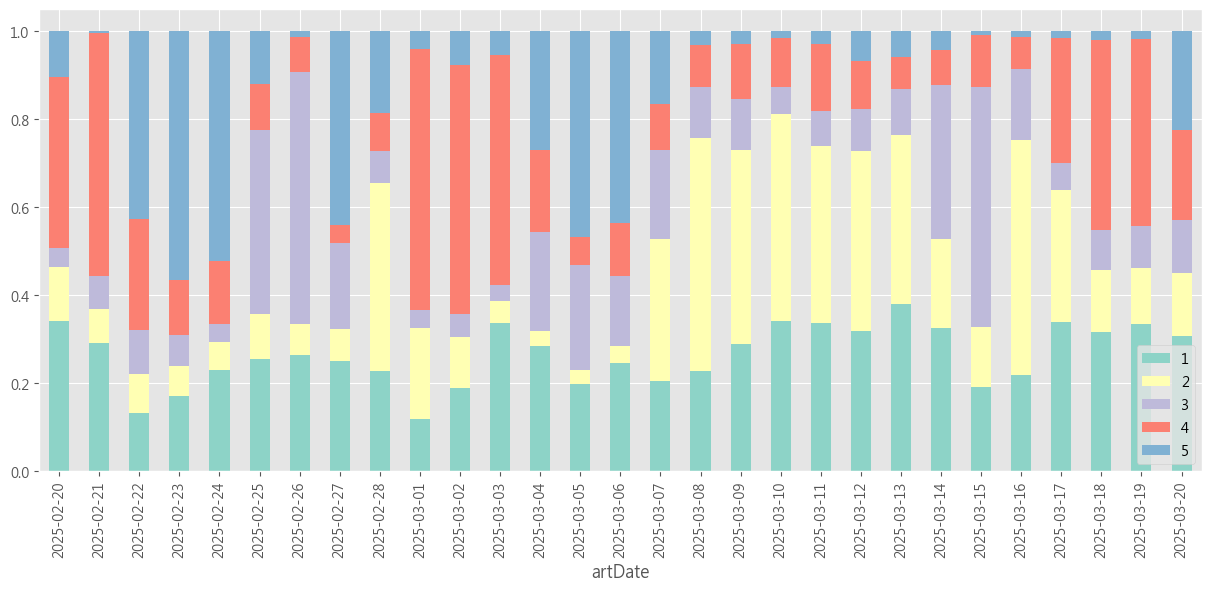

In [150]:
fig, ax = plt.subplots(figsize=(15, 6))
date_topic.plot.bar(ax=ax, stacked=True, color = plt.cm.Set3.colors)
ax.legend(loc='lower right')

可以看到主題 2（俄烏戰爭、國際安全與外交政策）明顯集中出現在 3/7–3/13 ，在這之間討論的比例高於其他主題，<br>
可能與該期間有關烏俄戰爭變化或外交會談的新聞報導集中有關，反映了目前國際上的安全和政治議題，<br>
主題 1（股市震盪）在整體時間範圍中皆穩定出現，反映出金融市場與經濟相關議題是媒體持續關注的焦點，<br>
並與主題 2 在時序上產生重疊（3/7-3/13有稍微上升），可能反映出戰爭情勢對市場動盪的連動影響。<br>